# <a id="top"></a>Non linear, differentiable optimization
<br>
<div class="alert alert-warning">**Preamble:**<br>
This notebook is long. Probably too long for a 3 or 4h class for most students. So the intention is not to finish it in that period of time.<br>
Instead, it is divided into 7 sections:<br>
Section 1 summarizes what you *must* know, which is developped in sections 2, 3 and 4.<br>
Sections 5, 6 and 7 contain supplementary material that is necessary for optimization engineers and scientists but that can be skipped for the purpose of this introductory class.<br>
Section 8 contains the problem that you must solve to get the credits for this class.
</div>
<br>
<div class="alert alert-info">**Target skills:**<br>
After this class you should be able to:
<ul><li> transform an optimization problem from its 'plain words' formulation to its mathematical formulation (part 2)
<li> explain what a gradient is (part 3)
<li> explain what convexity is (part 3)
<li> explain what a Hessian matrix is (part 3)
<li> explain what gradient descent is (part 3)
<li> implement a gradient descent algorithm (part 3)
<li> explain why the step size in gradient descent needs to be adapted (part 3)
<li> know the scipy.optimize.minimize function (part 3)
<li> formulate a contrained non-linear optimization problem and distinguish it from other problems (parts 2 and 4)
<li> know the scipy.optimize.fmin_slsqp function (part 4)
</ul>
</div>

If you go through the supplementary material, you should be able to:
- explain what a Hessian is (part 5)
- explain what function conditioning is (part 5)
- know the conjugate gradients, Newton conjugate gradient and BFGS methods (part 5)
- know the Karush-Kuhn-Tucker theory of constrained optimization (part 6)
- know how (sequential) quadratic programming works (part 7)

**Table of contents**
1. [What you must know (class summary)](#part1)
2. [Modeling optimization problems](#part2)
3. [Gradient Descent](#part3)
    1. [Descent algorithms](#part3.1)
    2. [Gradient descent with fixed step size](#part3.2)
    3. [A first attempt at adaptive step sizes](#part3.3)
    4. [Line search](#part3.4)
    5. [Convexity](#part3.5)
    6. [Adapting the descent directions to the function's conditioning](#part3.6)
4. [Constrained optimization](#part4)
5. [[Optional] Second order methods](#part5)
6. [[Optional] Introduction to the Karush-Kuhn-Tucker theory](#part6)
    1. [A graphical introduction](#part6.1)
    2. [The Lagrangian and Karush-Kuhn-Tucker's conditions](#part6.2)
    3. [Analytical resolution of nonlinear programming problems using the KKT conditions](#part6.3)
7. [[Optional] (Sequential) Quadratic programming](#part7)
8. [Exercice](#part8)

# 1. <a id="part1"></a>What you must know

This is a brief summary of the class' main results.
<div class="alert alert-success">
<ul>
<li> Job of the optimization scientist : 
<ol><li> transform plain words formulations into mathematical descriptions
<li> identify to what category of optimization problem they belong
<li> design the most appropriate resolution method or choose the best off-the-shelf numerical tool to solve it
<li> put it back into words and comment it
</ol>
<li> Differentiable optimization: optimization problems with continuous variables and differentiable objective function and constraints.
<li> Gradient of a function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ in $\hat{x}\in\mathbb{R}^n$. $$\nabla_x f(\hat{x})= \frac{\partial f}{\partial x}(\hat{x}) = \left(\begin{array}{c} \frac{\partial f}{\partial x_1}(\hat{x})\\ \vdots\\  \frac{\partial f}{\partial x_n}(\hat{x}) \end{array}\right)$$
<li> [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) provides a whole set of off-the-shelf optimization algorithms (plus some utility functions).
<li> Descent algorithms define a sequence $x_{k+1} = x_k + \alpha_k d_k$.
<li> Gradient descent algorithms take descent steps in the opposite direction of the gradient: $d_k = -\frac{\nabla_x f(x_k)}{\|\nabla_x f(x_k)\|}$
<li> Fixed step gradient descent finds a neighborhood of a local minimum but does not converges. It oscillates around the minimum.
<li> Line search consists in defining the univariate function $g(\alpha)=f(x_k+\alpha\cdot d_k)$ and minimizing this function to find the step size.
<li> When line search is used in gradient descent, two successive descent directions are always orthogonal $d_k^Td_{k-1} = 0$.
<li> A convex function is defined by the property $\forall (y,z)\in\mathbb{R}^n, \lambda \in [0,1], f(\lambda y + (1-\lambda) z) \leq \lambda f(y) + (1-\lambda) f(z)$.
<li> If $f$ is twice differentiable, its Hessian matrix in $x$ is:
$$H_f(x) = \nabla_x^2 f(x) = \left[ \begin{array}{ccc}
\frac{\partial^2 f}{\partial x_0^2} & \cdots & \frac{\partial^2 f}{\partial x_0 \partial x_n}\\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_0 \partial x_n} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{array}\right]$$
<li> $H_f(x)\textrm{ is a positive definite matrix} \Leftrightarrow f\textrm{ in convex in }x$
<li> A function's conditioning in $x$ is the ratio $\frac{M(x)}{m(x)}$ where $M(x)$ and $m(x)$ are respectively the largest and the smallest eigen-values of $H_f(x)$.
<li> The idea of the Conjugate Gradients method is to take successive descent directions that, instead of being orthogonal to each other in the standard coordinate system ($d_k^Td_{k-1} = 0$) are orthogonal to each other in the basis spanned by the columns of the Hessian $H$ in $x$, that is $d_k^T [H_f(x_k)] d_{k-1} = 0$. These descent directions are called $H$-conjugate (hence the name of the method) and can be computed iteratively without ever computing the Hessian, using the Polak-Ribiere formula:
$$d_{k} = -g_k + \frac{\left(g_k\right)^T \left(g_k - g_{k-1} \right)}{(g_{k-1})^Tg_{k-1}} d_{k-1}$$
The step size in the conjugate gradients method is found by line search.
<li> Conjugate gradients is available in [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) under the [`fmin_cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html) function.
<li> To solve general constrained optimization problems, one can use the [`fmin_slsqp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html) from `scipy.optimize`.
</ul>
</div>

# 2. <a id="part2"></a>Modeling optimization problems
[Link to top](#top)

Consider the two following situations.

> An aircraft design engineer comes to you and asks: "In the design department, we usually draw plans of the plane's wings and then try out different I-beam shape factors to test if they can resist the buckling loads suffered in-flight. But we're never really sure that we have the lightest possible beam and that is a problem since the lighter our beams are, the better our plane's propulsion performance. We've heard you mathematicians can help us find the best I-beam shapes."

<img width=300px src="img/raidisseur.png"></img>

> The geography department has lost its maps in a terrible fire. All that is left are some tables with the inter-city distances. Can you draw a map from this data that best fits those distances and find back the cities coordinates?

<img width=200px src="img/gps.png"></img>

Both of these problems are **optimization** problems. They correspond to situations where one wishes to find the **best** configuration among many possible solutions. The job of the optimization scientist or engineer is to transform such plain words formulations into mathematical descriptions, then identify to what category of optimization problem they belong, in order to design the most appropriate resolution method, or choose the best off-the-shelf numerical tool to solve it, and then put it back into words and comment it so that the solution is usable.

In this class, we focus on a particular class of optimization problems which can be cast using only **continuous variables** and for which we can write the optimization criterion as a **differentiable function**.

The optimization criterion is called the **objective function** and the variables that describe our different options are called **decision variables**.

Suppose we write $x$ the vector of problem variables and $f$ the objective function. The differentiable optimization problem is to find the value(s) of $x$ that minimize $f$: 
$$\min_{x\in \mathbb{R}^n} f(x)$$

<div class="alert alert-warning">**Exercice:**<br>
Write the set of variables for each of the two introductory problems. Write the objective function.
</div>
<br>

<div class="alert alert-danger"><a href="#answer1" data-toggle="collapse">**Answer (click to unfold):**</a><br>
<div id="answer1" class="collapse">
1. Aircraft design:<br>
We want to find the best beam shape and $L$ is fixed because it depends on the wing's geometry, so (based on the drawing provided by the design department) our variables are $x=(e,h,b)$.<br>
What the design department wants, is to find the lightest possible beam. So they want to minimize the beam mass. Apparently, they didn't talk about changing the steel alloy they're using (only the beam shape), so we will assume a constant density $\rho$. Therefore, the problem turns out to be the minimization problem:
$$f(x) = \rho L \left( 2eb+eh \right)$$
Note that $\rho$ and $L$ are fixed (provided by the engineering department).<br>
<br>
2. Maps reconstruction:<br>
Drawing a map consists in finding the cities' coordinates. Let's call $(x_c,y_c)$ the coordinates of city $c$ and let's call $[1,C]$ the integer interval of city indices. The vector of decision variables is then $x = (x_0,y_0, \ldots, x_C,y_C)$.<br>
We want to draw a map that respects the inter-city distances. We shall write $d_{ij}$ the distance between cities $i$ and $j$ ($(i,j)\in [1,C]^2$).<br>
So for each pair $(i,j)$, we want the two points $(x_i,y_i)$ and $(x_j,y_j)$ to be $d_{ij}$ apart.<br>
The distance between these two points is $d(i,j) = \sqrt{\left(x_i-x_j\right)^2 + \left(y_i-y_j\right)^2}$. So we want the difference $d(i,j) - d_{ij}$ to be as close to zero as possible. We can get rid of this ugly square root and write that it is equivalent to making the difference $d(i,j)^2 - d_{ij}^2$ as close to zero as possible. Consequently, we want to minimize the  quantity $\left(d(i,j)^2 - d_{ij}^2\right)^2$ and we want to minimize it for all pairs of cities. So our objective function is:
$$f(x) = \sum\limits_{i=1}^C \sum\limits_{j=1}^C \left(\left(x_i-x_j\right)^2 + \left(y_i-y_j\right)^2 - d_{ij}^2\right)^2$$
It is interesting to note that in the sum above, the same term appears twice: for the pairs $(i,j)$ and $(j,i)$. We can simplify our objective function by writing:
$$f(x) = \sum\limits_{i=1}^C \sum\limits_{j=i+1}^C \left(\left(x_i-x_j\right)^2 + \left(y_i-y_j\right)^2 - d_{ij}^2\right)^2$$
</div>
</div>

Often, when writing the decision variables and the objective function, we realize they are not sufficient to model our problem. For instance, in the aircraft design problem, we have an obvious, easy to manufacture, beam that minimizes $\left( 2eb+eh \right)$: if we take $e=0$ - that is zero thickness - then the volume is minimized, but it is not certain that was an acceptable beam for the design department. Was is missing is some restriction on the set of beams we look for.

In this particular example, the reason this zero-thickness beam is not acceptable is that it won't resist the in-flight buckling loads. When we ask the design department how we can express such resistance requirements, they answer that the load that can be handled by the beam can be written $\frac{\pi^2 E I}{L^2}$ where $I$ is the beam's moment of inertia $I = e\frac{h^2}{2}\left(\frac{h}{6}+b\right)$. Additionnaly, their previous calculations provide a value $P_{max}$ for the worst-case load suffered in flight. Consequently, we need our beam to respect:
$$P_{max}\leq \frac{\pi^2 E}{L^2} e\frac{h^2}{2}\left(\frac{h}{6}+b\right)$$

Such a relation is what we call a **constraint**. A constraint is an equality or an inequality involving the decision variables, that reduces the set of acceptable solutions for our optimization problem. Suppose the design department also tell us they cannot manufacture beams with a thickness smaller than $e_{min}$ and they need to have a beam's tail $b$ that is always equal to $10e$. Then globally, our design problem can be modeled as:
$$\left\{\begin{array}{c}
\min\limits_{(e,h,b) \in \mathbb{R}^3} \rho L \left( 2eb+eh \right)\\
P_{max}\leq \frac{\pi^2 E}{L^2} e\frac{h^2}{2}\left(\frac{h}{6}+b\right)\\
e\geq e_{min}\\
b = 10e
\end{array}\right.$$

The general case of optimization problems we consider will be written:
\begin{gather}
\min_x f(x)\\
h(x) \leq 0\\
g(x) = 0
\end{gather}

In the example above, we have:

$$h(e,h,b) = \left( \begin{array}{l} P_{max} - \frac{\pi^2 E}{L^2} e\frac{h^2}{2}\left(\frac{h}{6}+b\right)\\ e_{min}-e
\end{array}\right)$$
And :
$$g(e,h,b) = b-10e$$

This class on **differentiable optimization** will focus on problems cast using only **continuous variables** and for which we the objective function and constraints are all **differentiable functions**.

We can them **non-linear** because we do not make any assumptions (besides differentiability) on $f$, $g$ or $h$. By contrast, one of the next classes on linear optimization will focus on the specific case of linear functions.<br>
<br>
<div class="alert alert-warning">**Exercice:**<br>
Does the map reconstruction problem have constraints?
</div>
<br>
<div class="alert alert-danger"><a href="#answer2" data-toggle="collapse">**Answer (click to unfold):**</a><br>
<div id="answer2" class="collapse">
No.<br>
Although it is interesting to remark that the optimal solution is not unique. Suppose you know an optimal assignment for $x = (x_0,y_0, \ldots, x_C,y_C)$; now translate and/or rotate these points in the $(x,y)$-plane, you still have an optimal solution. Maybe forcing a first city's coordinates to $(0,0)$ and forcing the general map orientation will help make the solution unique. So introducing those constraints can prove useful.
</div>
</div>

Let's write the map reconstruction problem in a form that can be fed to an optimization solver. For this we will use the [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize) optimizers.

Let's first load the data we have and define our objective function.

In [2]:
import numpy as np

In [4]:
cities = """
Amsterdam Athens    Barcelona Berlin   Bucarest  Budapest Brussels Copenhagen
Dublin    Edinburgh Gibraltar Helsinki Istanbul  Kiev     Lisbon   London
Madrid    Milan     Moscow    Munich   Nantes    Oslo     Paris    Prague
Reykjavik Riga      Rome      Sofia    Stockholm Toulouse Vilnius  Warsaw
"""
cities = cities.split()
n = len(cities)

distances = np.load("cities_distances.npy")
print(distances.shape)
print(distances)

(32, 32)
[[ 0.          0.03875256  0.02215928 ...,  0.01803213  0.02453119
   0.01963371]
 [ 0.03875256  0.          0.03367378 ...,  0.03532616  0.03328786
   0.02857904]
 [ 0.02215928  0.03367378  0.         ...,  0.00454002  0.04029373
   0.03339679]
 ..., 
 [ 0.01803213  0.03532616  0.00454002 ...,  0.          0.03783249
   0.03113766]
 [ 0.02453119  0.03328786  0.04029373 ...,  0.03783249  0.          0.00704546]
 [ 0.01963371  0.02857904  0.03339679 ...,  0.03113766  0.00704546  0.        ]]


Note: you don't need to spend hours on the details of the function below. If you get how it is computed, it's great, otherwise you can admit that given an imput vector $x$ it computes the value of $f(x)$

In [5]:
def func(x):
    """ Compute the map reconstruction objective function.
    
    Vector reshaped for more readability.
    """
    res = 0
    x = np.array(x)
    x = x.reshape((n, 2))
    for i in range(n):
        for j in range(i+1, n):
            (xi, yi), (xj, yj) = x[i, :], x[j, :]
            delta = (xj - xi)**2 + (yj - yi)**2 - distances[i, j]**2
            res += delta**2
    return res

Since we are dealing with a differentiable optimization problem, our optimization algorithms can use the objective function's **gradient**. Recall that the gradient of a differentiable function is the vector of derivatives with respect to all its coordinates.

$$\nabla_x f = \frac{\partial f}{\partial x} = \left(\begin{array}{c} \frac{\partial f}{\partial x_1}\\ \vdots\\  \frac{\partial f}{\partial x_n} \end{array}\right)$$

A few words to recall what the gradient means. 
- Since the gradient's coordinates are equal to the derivatives in all directions, the gradient measures the *increase rate* in all directions.
- The gradient is a vector in $\mathbb{R}^n$ that points in the direction of the greatest increase rate. Its magnitude gives the slope in this direction.
- The function's slope in the direction of any unit vector $u$ is given by $u^T \nabla_x f(x)$.

In our case, we have:
$$f(x) = \sum\limits_{i=1}^C \sum\limits_{j=i+1}^C \left(\left(x_i-x_j\right)^2 + \left(y_i-y_j\right)^2 - d_{ij}^2\right)^2$$

So (after a somehow tedious calculation):
$$\frac{\partial f}{\partial x_k}(x) = \sum\limits_{i=1}^C \sum\limits_{j=i+1}^C 4 \left(\left(x_i-x_j\right)^2 + \left(y_i-y_j\right)^2 - d_{ij}^2\right) \left(x_i-x_j\right)(\mathbb{1}_{i=k} - \mathbb{1}_{j=k})$$
And we have a similar formula for $\frac{\partial f}{\partial y_k}(x)$.

In [6]:
def func_der(x):
    """ Derivative of the map reconstruction objective function.
    
    Note: (f \circ g)' = g' \times f' \circ g
    Vector reshaped for more readability.
    """
    res = np.zeros((n, 2))
    #x = np.array(x)
    x = x.reshape((n, 2))
    for i in range(n):
        for j in range(i+1, n):
            (xi, yi), (xj, yj) = x[i, :], x[j, :]
            delta = (xj - xi)**2 + (yj - yi)**2 - distances[i, j]**2
            res[i, 0] += 4 * (xi - xj) * delta
            res[i, 1] += 4 * (yi - yj) * delta
            res[j, 0] += 4 * (xj - xi) * delta
            res[j, 1] += 4 * (yj - yi) * delta
    return np.ravel(res)

Most optimization algorithms have a starting point $x_0$. They search the set of allowed points starting from $x_0$. Let's pick this one at random.

In [7]:
# initial random position
x0 = np.random.normal(size=(n, 2))
print(x0)

[[-0.49435187 -0.55933184]
 [ 0.71316857  2.42600724]
 [-0.91807409  0.0137966 ]
 [-1.59487878  0.57065617]
 [-0.47006534 -1.1084932 ]
 [-0.03665723  0.70122472]
 [-0.34931093 -0.08948942]
 [ 0.3072082   0.07490981]
 [ 1.59525411 -0.45025237]
 [ 0.48721106  0.59640695]
 [ 0.34549648  1.60825496]
 [-0.36546088 -0.31649361]
 [ 0.8082033  -0.69381005]
 [-2.23882917  0.5933057 ]
 [ 0.15594211  0.94104422]
 [-0.90794889  0.2406601 ]
 [-0.97482017  0.91643176]
 [ 0.24488524 -0.19547545]
 [ 1.18678223 -0.9959653 ]
 [ 0.53661855 -1.93280674]
 [-0.98655301  0.19449304]
 [ 1.76932572 -0.26132395]
 [-1.96891891 -0.8255889 ]
 [ 1.06413046  0.38322506]
 [ 0.37823012  0.07729763]
 [ 2.13399629 -0.54766103]
 [-0.2173417   1.82658248]
 [-1.13828165  0.15639355]
 [ 0.98880648  1.9465354 ]
 [-1.4148867   1.9221608 ]
 [ 0.81752148 -0.1895642 ]
 [-0.73926638 -3.01072888]]


Now we are ready to call our optimization solver. We could use the generic [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function which allows to call every other minimizer in `scipy.optimize` using the `method` parameter. We will use the BFGS function so [`method=BFGS`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs) which can be equivalently called using [`scipy.optimize.fmin_bfgs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html#scipy.optimize.fmin_bfgs) for a finer control over the optimization parameters. You are strongly encouraged to take a few minutes to review its syntax to get a sense of the following lines.

In [8]:
import scipy.optimize as sopt
solution = sopt.fmin_bfgs(func, x0, fprime=func_der, retall=True)
## The line above is almost equivalent to the commented line below.
## The only difference is in the format of the returned solution.
#solution = sopt.minimize(func, x0, method='BFGS', jac=func_der, options={'disp':True, 'return_all':True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 548
         Function evaluations: 589
         Gradient evaluations: 589


The BFGS algorithm seems to have found  a solution. Setting the `retall` (return all) option to `True` allowed us to keep track of all the intermediate points the algorithm went throught (from $x_0$ to the optimal value of $x$). We shall call these points the *convergence path* and access them as `solution[1]` (as explained in the function's documentation). We will use these points to plot the "trajectory" of the cities on the map along the iterations, from the initial guess $x_0$ to their optimal location.

As stated previously, the value found for $x$ remains optimal after any rotation, translation or mirroring in the $(x,y)$-plane so we actually have infinitely many solutions. Fortunately:
- we can use the fact that Rome and Copenhagen are almost North-South aligned to fix the map's orientation;
- we know that Reykjavik is west of Moscow, so we can decide whether a mirroring is necessary.

In [9]:
res = solution[0].reshape((n, 2))

# rotate it so that Copenhagen is North of Rome
south, north = cities.index("Rome"), cities.index("Copenhagen")
d = res[north, :] - res[south, :]
rotate = np.arctan2(d[1], d[0]) - np.pi/2
mat_rotate = np.array([[np.cos(rotate), -np.sin(rotate)],
                       [np.sin(rotate), np.cos(rotate)]])
res = res @ mat_rotate 


# mirror so that Reykjavik is west of Moscow
west, east = cities.index("Reykjavik"), cities.index("Moscow")
mirror = False
if res[west, 0] > res[east, 0]:
    mirror = True
    res[:, 0] *= -1

# apply the transformation to the full convergence path 
path = [p.reshape((n, 2)) @ mat_rotate for p in solution[1]]
if mirror:
    path = [p * np.array([-1, 1]) for p in path]

And we can now plot all cities' positions along the convergence path.

We manually set different parameters:
- we trim the image 10% outside the square hull of the cities' positions;
- we use colormaps to put some sense in this spaghetti soup;
- we manually chose label placements so as to avoid overlaps and improve readability.

Note that this last item could be subject to automated optimisation.

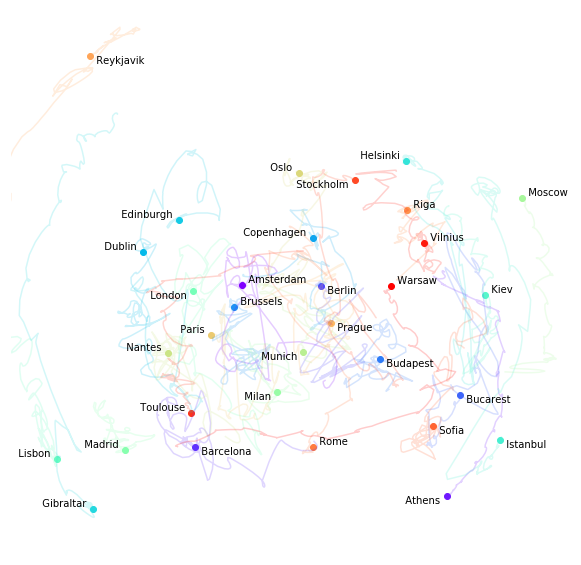

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

# Trimming the final image

bx = min(res[:, 0]), max(res[:, 0])
dx = bx[1] - bx[0]
ax.set_xlim(bx[0] - .1*dx, bx[1] + .1*dx)

by = min(res[:, 1]), max(res[:, 1])
dy = by[1] - by[0]
ax.set_ylim(by[0] - .1*dy, by[1] + .1*dy)


# label placement: subject to automatic optimization!
from collections import defaultdict
d = defaultdict(lambda: {'ha': "left", 'va': "bottom"})

for city in ["Barcelona", "Berlin", "Bucarest", "Budapest",
             "Istanbul", "Prague", "Reykjavik", "Sofia", ]:
    d[city] = {'ha': "left", 'va': "top"}
for city in ["Athens", "London", "Munich",  "Milan",
             "Stockholm", ]:
    d[city] = {'ha': "right", 'va': "top"}
for city in ["Copenhagen", "Dublin", "Edinburgh", "Gibraltar",
             "Helsinki", "Lisbon", "Madrid", "Nantes", "Oslo",
             "Paris", "Toulouse", ]:
    d[city] = {'ha': "right", 'va': "bottom"}
    
# automatic colouring
colors = cm.rainbow(np.linspace(0, 1, n))
    
for i, ((x, y), city, color) in enumerate(zip(res, cities, colors)):
    t = np.array([t[i, :] for t in path[150:]])
    ax.plot(t[:, 0], t[:, 1], color=color, alpha=.2)
    ax.scatter(x, y, color=color)
    ax.annotate("  " + city + "  ", (x, y), **d[city])

What do you think? Does that look like a reasonable map of Europe?

You might want to display different portions of the convergence path to get an idea of what is happening.

<div class="alert alert-info">
Let's wrap everything up. So far we have:
<ol>
<li> transformed a "plain words" problem description into its mathematical optimization model;
<li> characterized the family of differentiable optimization problems;
<li> recalled what a gradient is;
<li> implemented functions that compute our objective function and its gradient so that we can feed them to an optimization solver;
<li> chosen and called the `fmin_bfgs` solver from `scipy.optimize` to find an optimal solution;
<li> created a nice visualization to present the results and comment them.
</ol>
</div>

Now that we have an overview of the workflow of optimization tasks, we can dive into more details on the optimization algorithms.

# 3. <a id="part3"></a>Gradient descent
[Link to top](#top)

In this section, we concentrate on finding the minimum of a given differentiable function $f$. Try to keep on mind the general illustration from section 1 to keep track of why we do this.

In order to make things didactic and graphical, we shall work on functions from $\mathbb{R}^2$ to $\mathbb{R}$, which can be easily plotted (either as surfaces in 3D or as contour plots in 2D).

## 3.1 <a id="part3.1"></a>Descent algorithms

Descent algorithms define a sequence of steps "rolling down" the function's surface (similarly to how water would flow down from a mountain), that is a sequence of points $x_k$ of decreasing value $f(x_k)$. To construct this sequence, one defines at each step a descent direction $d_k$ and a descent step $\alpha_k$. The next point in the sequence is thus $x_{k+1} = x_k + \alpha_k d_k$.

Since the gradient $\nabla f$ of $f$ indicates the steepest ascent direction, $-\nabla f$ is a descent direction, hence the name **gradient descent**.

Let's illustrate that. You don't need to read the full formula of the function below, but for your curiosity, it is built as follows:
\begin{align}
&(x'_0, x'_1) = rotate_{\pi/6}(x_0,x_1)\\
&g(z_0,z_1) = \left( a_3 z_0^3 + a_2 z_0^2 + a_1 z_0 + a_0 \right) \left( b_2 z_1^2 + b_1 z_1 + b_0 \right)\\
&f(x_0,x_1) = g\left(rotate_{\pi/6} \left(x_0,x_1\right)\right)\\
&\textrm{with }[a_3, a_2, a_1, a_0] = [0.019217, 0.013158, -0.423455, -0.247614, 4.]\\
&\textrm{and }[b_2, b_1, b_0] = [0.1, 0., 0.1]
\end{align}

In [11]:
def func(x):
    a = np.pi/6.
    c = np.cos(a)
    s = np.sin(a)
    #Next the coordinates x and y are rotated
    xx = c*x[0]+s*x[1]
    yy = -s*x[0]+c*x[1]
    p = np.poly1d([0.019217057452351031, 0.013158736688148412, -0.42345571095569301, -0.24761472187941180, 4.])
    q = np.poly1d([0.1, 0., 0.1])
    return p(xx)*q(yy)

def func_der(x):
    a = np.pi/6.
    c = np.cos(a)
    s = np.sin(a)
    xx = c*x[0]+s*x[1]
    yy = -s*x[0]+c*x[1]
    p = np.poly1d([0.019217057452351031, 0.013158736688148412, -0.42345571095569301, -0.24761472187941180, 4.])
    pp = np.polyder(p)
    q = np.poly1d([0.1, 0., 0.1])
    qq = np.polyder(q)
    grad0 = c*pp(xx)*q(yy) - s*qq(yy)*p(xx)
    grad1 = s*pp(xx)*q(yy) + c*qq(yy)*p(xx)
    return np.array([grad0, grad1]).T

Let's first plot this function. Again, you don't need a deep understanding of the plotting functions below.
- The first one plots a function $f$ in 3D;
- The second one plots the contour levels of function $f$ in 2D, with several options to plot the function's gradient in specific points.

An example is provided below.

In [13]:
from mpl_toolkits.mplot3d import axes3d

def plot_3d_func(f, X0, X1):
    """Plots function f over the grid of X0 and X1 arguments (X0 and X1 should be numpy arrays)."""
    X = np.meshgrid(X0, X1)
    Z = f(X)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X[0], X[1], Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha=0.3)
    #cset = ax.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

def plot_contours_func(f, X0, X1, 
                       levels = np.array([]), 
                       xp = np.empty((2,0)), 
                       plot_line = False,
                       f_der = None, 
                       add_levels=True):
    """Contour plot of function f.
    X0 and X1 should be numpy arrays defining a grid over which the contour plot will be drawn.
    levels should be a numpy array providing user-defined contour levels (otherwise, 10 regularly spaced levels are generated)
    xp should be a (2,n)-numpy array of (x0,x1)-coordinates for additional points to plot on the graph
    plot_line indicates whether a line should be plotted between the xp points
    f_der should be a function returning the derivative of f when evaluated in (x0,x1). It is used to plot the gradient in xp. If f_der=None no derivatives will be plotted
    add_levels indicates whether to add the contour levels for the xp points
    """
    X = np.meshgrid(X0, X1)
    Z = f(X)
    fig = plt.figure()
    fig.set_size_inches(10,10)
    plt.axis('equal')
    if(np.equal(len(levels),0)):
        levels = np.arange(np.min(Z), np.max(Z), (np.max(Z) - np.min(Z)) / 10.)
    if(np.not_equal(xp.shape[1],0)):
        z = f(xp)
        if(add_levels):
            levels = np.append(levels, z)
        plt.scatter(xp[0,:],xp[1,:], cmap=cm.autumn, c=-np.arange(xp.shape[1]), edgecolors='black')
        if(plot_line):
            plt.plot(xp[0,:],xp[1,:])
        if(np.not_equal(f_der,None)):
            grad = f_der(xp)
            plt.quiver(xp[0,:], xp[1,:], grad[:,0], grad[:,1])
    levels = np.sort(levels)
    cont = plt.contour(X[0],X[1],Z,levels)
    plt.clabel(cont, cont.levels, inline=True, fontsize=10)

#help(plot_3d_func)
#help(plot_contours_func)

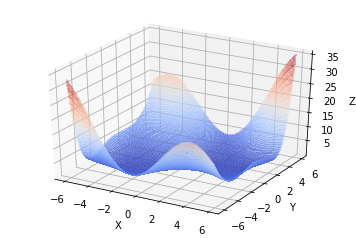

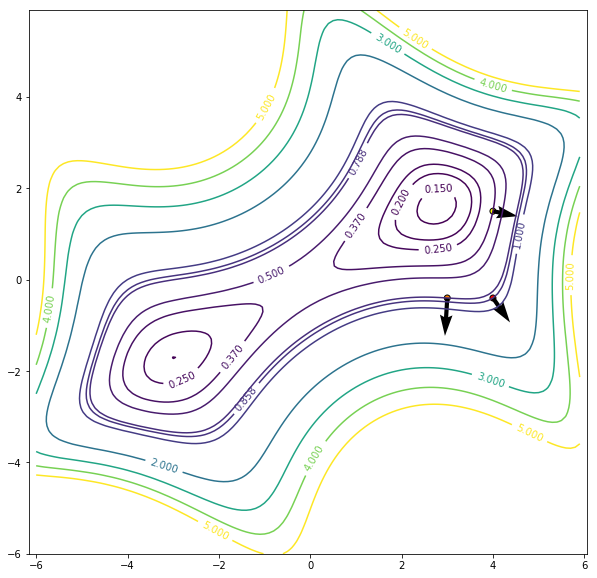

In [14]:
X0 = np.arange(-6,6,0.1)
X1 = np.arange(-6,6,0.1) #Y = np.arange(-3,3,0.1)
xd = np.array([[4.,3.,4.],[1.5,-0.4,-0.4]])
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_3d_func(func, X0, X1)
plot_contours_func(func, X0, X1, levels, xp=xd, f_der=func_der)

## 3.2 <a id="part3.2"></a>Gradient descent with fixed step size

Let's take a starting point $x_0$ and write a gradient descent procedure that build the sequence of points $x_{k+1} = x_k + \alpha_k d_k$ with $d_k = -\frac{\nabla_x f(x_k)}{\|\nabla_x f(x_k)\|}$ (that is a unit vector in the opposite direction of the gradient) and a fixed step size $\alpha_k$.

<div class="alert alert-warning">**Exercice:**
<ul>
<li> Write an algorithm that starts in $(-5,-4)$ and uses gradient descent on the `func` function defined above, with fixed-length steps of length $\alpha = 0.1$, for 20 steps (if you need to compute the norm of a vector, use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)).
<li> Use `plot_contours_func` to plot the sequence of points obtained.
<li> Did the algorithm find the minimum? Were there enough steps? Increase the number of steps until you reach a vicinity of the minimum.
<li> What are the coordinates of this minimum? What is the value of $f$ there? Is this a local or a global minimum?
<li> How far do you get from the true minimum?
<li> Restart your algorithm at $(4,-4)$, do you obtain the same result?
</ul>
</div>

fopt: 0.132377974697
xopt: [ 2.75319442  1.67024008]


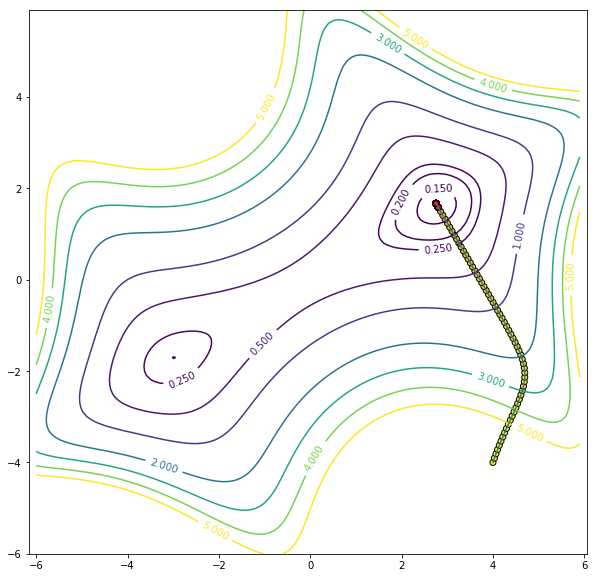

In [15]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

Nsteps = 200
alpha = 0.1
X = np.zeros((Nsteps, 2))
X[0,:] = np.array([4,-4])
for i in range(1,Nsteps):
    grad = func_der(X[i-1,:])
    d = -grad / np.linalg.norm(grad)
    X[i,:] = X[i-1,:] + alpha*d

X0 = np.arange(-6,6,0.1)
X1 = np.arange(-6,6,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func, X0, X1, levels=levels, xp=X.T, plot_line=True, add_levels=False)
print("fopt:", func(X[Nsteps-1,:]))
print("xopt:", X[Nsteps-1,:])

#With 20 steps the algotirhm does not reach the minimun so it is necessary to increase the number of steps; for example
#to 40 steps.

#The coordinates are approximately [-3.01184796 -1.66637191]; the value of f is 0.200404146161
#It is a local minimun because the function reaches values even smaller

#The global can not be reach unless the algorithm starts at a different point because the gradient became 0

#By changing the initial point to 4,-4 the result chages and the global minimun is reached

Recall that the gradient's norm in $x$ is the steepest increase rate of the function in $x$. So as long as this norm is non-zero, it means we can still move up or down the function's surface by following the gradient's direction. Conversely, if the gradient becomes zero, it means we have reached a "flat" area in the function's surface, which is likely to be a (local) minimum.

<div class="alert alert-warning"> **Exercice:**
Copy-paste your code from the previous cells in the cell below to modify it. We'll work from the initial point $(x_0,x_1)=(-5,-4)$ in this exercice.
<ul>
<li> Is there a better way to stop the algorithm than a predefined number of steps? For example using the gradient's norm?
<li> Plot the evolution of the gradient's norm (actually you'll see it's clearer to plot the [log](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) of the gradient's norm) along the 100 first iterations. Is the norm of the gradient always a good way to control the algorithm's stopping? What happens after (around) the 34th iteration?
<li> Plot the sequence of points after iteration 34 by using `plot_contours_func` on the $[-3.05,-2.9]\times[-1.8,-1.6]$ domain.
<li> Also plot the (log of the) value of the objective function after iteration 34.
</ul>
</div>

Iteration 1 grad_norm = 3.969911098
Iteration 2 grad_norm = 3.49482132801
Iteration 3 grad_norm = 3.06235310545
Iteration 4 grad_norm = 2.67067550126
Iteration 5 grad_norm = 2.31827434417
Iteration 6 grad_norm = 2.00394507668
Iteration 7 grad_norm = 1.72672952962
Iteration 8 grad_norm = 1.48575286401
Iteration 9 grad_norm = 1.27991802776
Iteration 10 grad_norm = 1.10746422891
Iteration 11 grad_norm = 0.965522258619
Iteration 12 grad_norm = 0.849946115807
Iteration 13 grad_norm = 0.755669084984
Iteration 14 grad_norm = 0.67749893859
Iteration 15 grad_norm = 0.61091696732
Iteration 16 grad_norm = 0.552493359005
Iteration 17 grad_norm = 0.499880275263
Iteration 18 grad_norm = 0.451578758263
Iteration 19 grad_norm = 0.406669427101
Iteration 20 grad_norm = 0.364596765348
Iteration 21 grad_norm = 0.325022605153
Iteration 22 grad_norm = 0.287734956901
Iteration 23 grad_norm = 0.252593950706
Iteration 24 grad_norm = 0.219500615739
Iteration 25 grad_norm = 0.188379094877
Iteration 26 grad_norm 

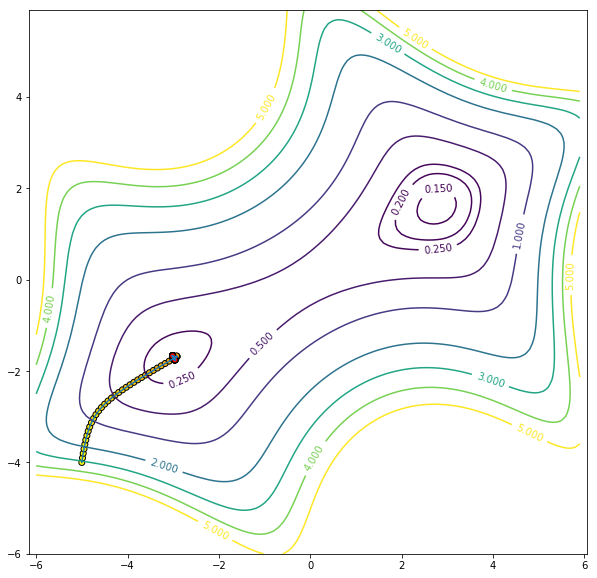

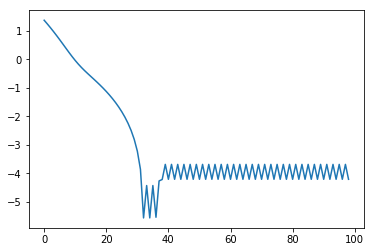

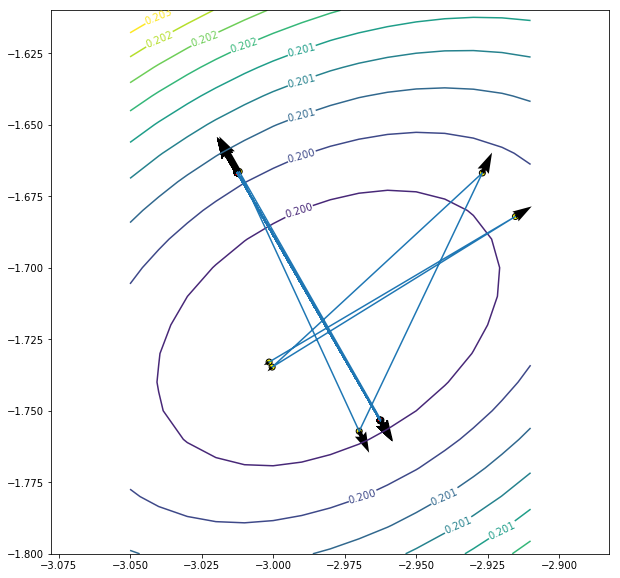

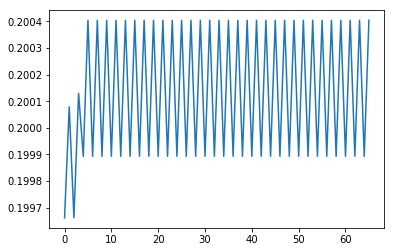

In [16]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

maxSteps = 100
alpha = 0.1
epsilon = 0.001
X = np.zeros((maxSteps, 2))
X[0,:] = np.array([-5,-4])
grad_norm_tab = np.zeros(maxSteps)
grad_norm = np.linalg.norm(func_der(X[0,:]))
val_tab = np.zeros(maxSteps)
val_tab[0] = func(X[0,:])
i = 1
while i<maxSteps and grad_norm>epsilon:
    grad = func_der(X[i-1,:])
    grad_norm = np.linalg.norm(grad)
    grad_norm_tab[i-1] = grad_norm
    print("Iteration", i, "grad_norm =", grad_norm)
    d = -grad/grad_norm
    X[i,:] = X[i-1,:] + alpha*d
    val_tab[i] = func(X[i,:])
    i+=1
X = X[:i,:]
grad_norm_tab = grad_norm_tab[:i]
val_tab = val_tab[:i]

X0 = np.arange(-6,6,0.1)
X1 = np.arange(-6,6,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func, X0, X1, levels=levels, xp=X.T, plot_line=True, add_levels=False)
print("Nb iterations", i, "grad_norm =", grad_norm)
print("fopt:", func(X[i-1,:]))
print("xopt:", X[i-1,:])
plt.figure()
#print(grad_norm_tab)
plt.plot(np.log(grad_norm_tab[:-1]))
X0 = np.arange(-3.05,-2.9,0.01)
X1 = np.arange(-1.8,-1.6,0.01)
plot_contours_func(func, X0, X1, xp=X[34:,].T, plot_line=True, add_levels=False, f_der=func_der)
plt.figure()
plt.plot(val_tab[34:]);

#The norm of the gradient is not useful when we are so close to the minimun if a fixed step is applied. This is because
#the normal oscillates around the final result.
#The oscillation starts in the 34th iteration once the minimum has been reached


Apparently, depending on the value of the threshold we put on the gradient's norm, the algorithm does not terminate. In all cases, fixed-step sizes do not allow us to reach the local minimum but rather oscillate around it. So it seems we need adaptive, decreasing step-sizes. Any ideas as to what values we should pick for the step-size?

## 3.3 <a id="part3.3"></a>A first attempt at adaptive step sizes

<div class="alert alert-warning"> **Exercice:** Try implementing a step-size equal to the gradient's norm (again, copy-paste your code from the previous cells to avoid rewriting everything).
<ul>
<li> Stop the algorithm when the gradient's norm falls below $0.001$
<li> How many iterations until convergence?
</ul>
</div>

Iteration 1 grad_norm = 3.969911098
Iteration 2 grad_norm = 3.49482132801
Iteration 3 grad_norm = 3.06235310545
Iteration 4 grad_norm = 2.67067550126
Iteration 5 grad_norm = 2.31827434417
Iteration 6 grad_norm = 2.00394507668
Iteration 7 grad_norm = 1.72672952962
Iteration 8 grad_norm = 1.48575286401
Iteration 9 grad_norm = 1.27991802776
Iteration 10 grad_norm = 1.10746422891
Iteration 11 grad_norm = 0.965522258619
Iteration 12 grad_norm = 0.849946115807
Iteration 13 grad_norm = 0.755669084984
Iteration 14 grad_norm = 0.67749893859
Iteration 15 grad_norm = 0.61091696732
Iteration 16 grad_norm = 0.552493359005
Iteration 17 grad_norm = 0.499880275263
Iteration 18 grad_norm = 0.451578758263
Iteration 19 grad_norm = 0.406669427101
Iteration 20 grad_norm = 0.364596765348
Iteration 21 grad_norm = 0.325022605153
Iteration 22 grad_norm = 0.287734956901
Iteration 23 grad_norm = 0.252593950706
Iteration 24 grad_norm = 0.219500615739
Iteration 25 grad_norm = 0.188379094877
Iteration 26 grad_norm 

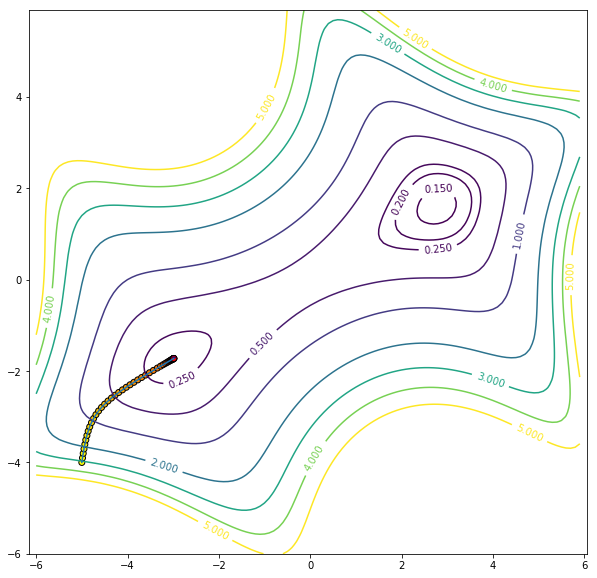

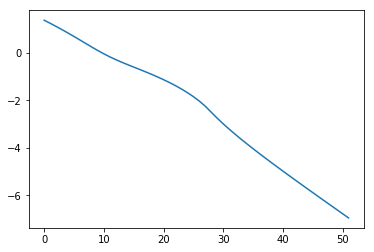

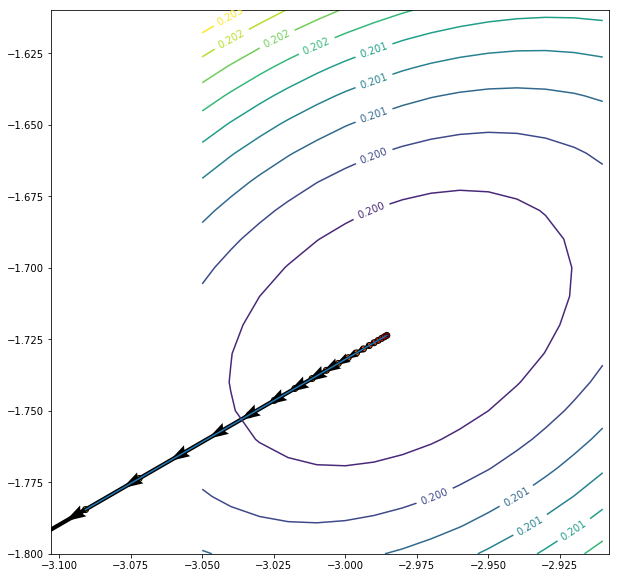

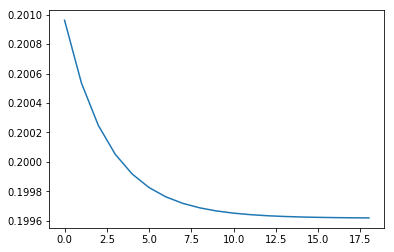

In [17]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

maxSteps = 100
alpha = 0.1
epsilon = 0.001
X = np.zeros((maxSteps, 2))
X[0,:] = np.array([-5,-4])
grad_norm_tab = np.zeros(maxSteps)
grad_norm = np.linalg.norm(func_der(X[0,:]))
val_tab = np.zeros(maxSteps)
val_tab[0] = func(X[0,:])
i = 1
while i<maxSteps and grad_norm>epsilon:
    grad = func_der(X[i-1,:])
    grad_norm = np.linalg.norm(grad)
    if grad_norm < alpha:
        alpha = grad_norm
    grad_norm_tab[i-1] = grad_norm
    print("Iteration", i, "grad_norm =", grad_norm)
    d = -grad/grad_norm
    X[i,:] = X[i-1,:] + alpha*d
    val_tab[i] = func(X[i,:])
    i+=1
X = X[:i,:]
grad_norm_tab = grad_norm_tab[:i]
val_tab = val_tab[:i]

X0 = np.arange(-6,6,0.1)
X1 = np.arange(-6,6,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func, X0, X1, levels=levels, xp=X.T, plot_line=True, add_levels=False)
print("Nb iterations", i, "grad_norm =", grad_norm)
print("fopt:", func(X[i-1,:]))
print("xopt:", X[i-1,:])
plt.figure()
#print(grad_norm_tab)
plt.plot(np.log(grad_norm_tab[:-1]))
X0 = np.arange(-3.05,-2.9,0.01)
X1 = np.arange(-1.8,-1.6,0.01)
plot_contours_func(func, X0, X1, xp=X[34:,].T, plot_line=True, add_levels=False, f_der=func_der)
plt.figure()
plt.plot(val_tab[34:]);

#53 iterations are necessaty before convergence

So apparently, taking a step length proportional to the gradient seems like a good idea. It makes sense intuitively since the norm of the gradient indicates how steep the function is locally, so, the steepest the surface, the biggest the step we can expect to make.<br>
<br>
However, this intuition can be proven very (very) wrong! In particular, taking a step size equal to the gradient's norm can be catastrophic. To convince yourself, consider the function $f(x)=10\cos(x)$ on the $[0,2\pi$] domain and check below what happens on the first step of gradient descent from $x=\pi/2$. <br>

First point x0: 1.5707963267948966
Gradient in x0: -10.0
Second point x1=x0-grad0: 11.5707963268


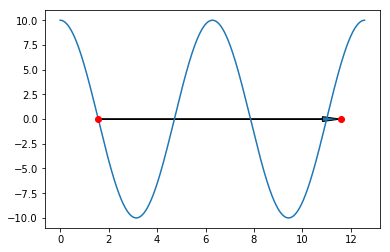

In [18]:
X = np.arange(0, 4*np.pi, 0.01)
Z = 10.*np.cos(X)
plt.figure()
plt.plot(X,Z)
x0 = np.pi/2.
val0 = 10.*np.cos(x0)
plt.plot(x0,0.,'ro')
grad0 = -10.*np.sin(x0)
x1 = x0 - grad0
val1 = 10.*np.cos(x1)
plt.arrow(x0,0., -grad0, 0., head_width=0.5, length_includes_head=True)
plt.plot(x1,0.,'ro')
print("First point x0:", x0)
print("Gradient in x0:", grad0)
print("Second point x1=x0-grad0:", x1)

## 3.4 <a id="part3.4"></a>Line search

So the gradient gives the steepest descent direction locally but this does not give any reliable information as to the best step size. We learn from this that the step size needs to adapt to the actual function in order for the sequence $f(x_k)$ to actually be decreasing. This is generally done via **line search**. Once a descent direction $d_k$ has been chosen in $x_k$, line search consists in defining the univariate function $g(\alpha)=f(x_k+\alpha\cdot d_k)$ and minimizing this function. Then, the found value for $\alpha$ is used as $\alpha_k$ and the process is repeated from $x_{k+1}=x_{k} + \alpha_k d_k$.<br>
<br>
The minimization of the scalar function $g$ can be done in a number of ways:
<ul>
<li> If $g'(\alpha)=0$ can be easily solved analytically, then it provides a series of candidates for a minimum. 
<li> Interpolation methods such as Cubic interpolation, Quadratic interpolation (Brent method) or the Golden section method (all left to your curiosity), that do not require the knowledge of an analytical form of $g'$ can be used to narrow down a minimum.
</ul>

Fortunately for us, `scipy.optimize` provides a [`minimize_scalar`](https://docs.scipy.org/doc/scipy-0.17.1/reference/generated/scipy.optimize.minimize_scalar.html) function that performs this tedious line search for us.

Those interested in going further on the topic of step size selection in descent methods can check the following advanced topics (do that later if you are curious, or you probably won't have time to finish this notebook):
<ul>
<li> Armijo rule and Wolfe conditions
<li> Goldstein rule
<li> Robbins-Monro stochastic approximation
</ul>

Before going any further, let us recall an important property. With the line search procedure we just introduced, two successive descent directions are necessarily orthogonal. Why? Simply because if $d_{k+1}$ was not orthogonal to $d_k$, that would mean there is a component of $d_{k+1}$ along $d_k$, which would mean that in $x_{k+1}$, it would still be possible to decrease $f$ just by moving along the $d_k$ direction, but this is obviously impossible since $x_{k+1}$ is the minimum of $f(x_k+\alpha\cdot d_k)$. So $d_{k+1}$ is necessarily orthogonal to $d_k$.<br>
<br>
Note that, in dimension 2, that leaves little choice for the direction $d_{k+1}$ given $d_k$. But in higher dimensions, there is an infinity of unit vectors that are orthogonal to $d_k$, so what this property says really is just that two successive descent directions are orthogonal and nothing else.
<div class="alert alert-warning"> **Exercice:** Just take a minute to make sure you understood this property.<br>
</div>
<div class="alert alert-warning">**Exercice:**<br>
Now, reuse your previous code to write a descent method where the descent direction is the normalized gradient and the step size is found by line search.<br>
<ul>
<li> Can you confirm the above property (graphically)?
<li> How many steps until convergence?
</ul>
</div>

Nb iterations 10 grad_norm = 0.000600918185623
fopt: 0.199616866833
xopt: [-2.98228805 -1.72141746]


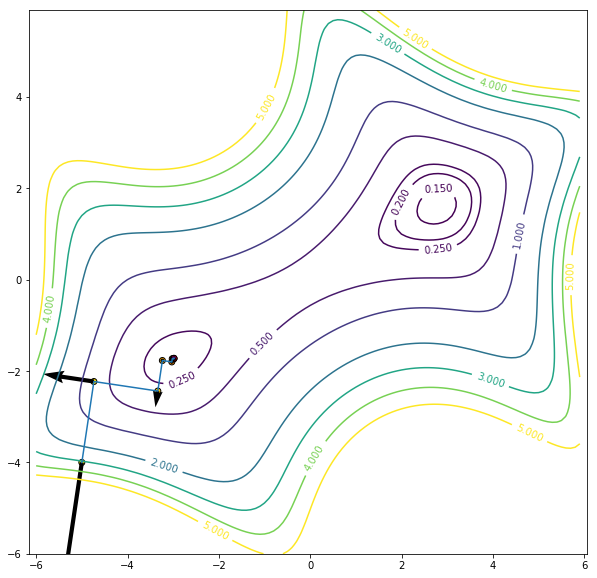

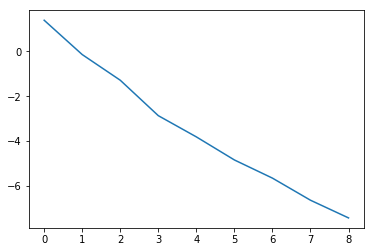

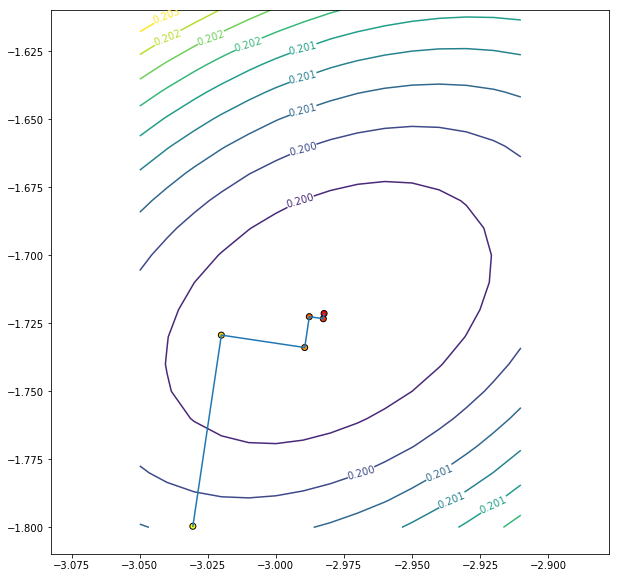

In [19]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

maxSteps = 19
epsilon = 0.001
X = np.zeros((maxSteps, 2))
X[0,:] = np.array([-5,-4])
grad_norm_tab = np.zeros(maxSteps)
grad_norm = np.linalg.norm(func_der(X[0,:]))
val_tab = np.zeros(maxSteps)
val_tab[0] = func(X[0,:])
i = 1
while i<maxSteps and grad_norm>epsilon:
    grad = func_der(X[i-1,:])
    grad_norm = np.linalg.norm(grad)
    grad_norm_tab[i-1] = grad_norm
    #print("Iteration", i, "grad_norm =", grad_norm)
    d = -grad/grad_norm
    def g(alpha):
        return func(X[i-1,:] + alpha*d)
    res = sopt.minimize_scalar(g)
    alpha = res.x
    X[i,:] = X[i-1,:] + alpha*d
    val_tab[i] = func(X[i,:])
    i+=1
X = X[:i,:]
grad_norm_tab = grad_norm_tab[:i]
val_tab = val_tab[:i]

X0 = np.arange(-6,6,0.1)
X1 = np.arange(-6,6,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func,X0,X1,levels=levels,xp=X.T,plot_line=True,add_levels=False,f_der=func_der)
print("Nb iterations", i, "grad_norm =", grad_norm)
print("fopt:", func(X[i-1,:]))
print("xopt:", X[i-1,:])
plt.figure()
plt.plot(np.log(grad_norm_tab[:i-1]))
X0 = np.arange(-3.05,-2.9,0.01)
X1 = np.arange(-1.8,-1.6,0.01)
plot_contours_func(func,X0,X1,xp=X[4:,:].T,plot_line=True,add_levels=False)

#The componentes of the gradient are orthogonal and the number of iterations is 10, so it converges to the solution before
#previous algorithms.

Did you notice the orthogonal descent directions?

## 3.5 <a id="part3.5"></a>Convexity

Let's take a step back and consider the general question of finding minimas of differentiable functions. So far, what we have intuitively done corresponds to saying that if we roll down the function's surface in the opposite direction of the gradient, we might end up in a zero-gradient point that is a local minimum.

We could do that precisely because our functions were differentiable; their gradient exists.

But the reverse implication is not true: zero-gradient points are not necessarily minimas! Consider the two following functions.

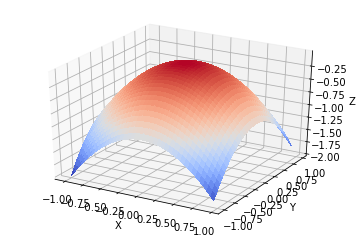

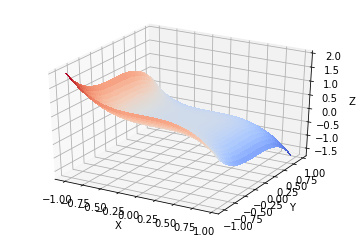

In [20]:
X0 = np.arange(-1.,1.,0.05)
X1 = np.arange(-1.,1.,0.05)
X = np.meshgrid(X0, X1)
Z = -X[0]*X[0]-X[1]*X[1]
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X[0], X[1], Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Z = -X[0]*X[0]*X[0]-X[1]*X[1]*X[1]
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X[0], X[1], Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

Both these functions have a null gradient in $(0,0)$ but neither have a minimum in $(0,0)$.

So "$\hat{x}$ is a minimum $\Rightarrow$ $\nabla_x f(\hat{x}) = 0$" is true but the reverse implication is false.

Take a point $x$ where the surface is flat (with a zero gradient). To guarantee that this point is a (local) minimum we need to guarantee that the fonction is (locally) **convex** around this point. Technically, that means that for any two points $y$ and $z$, if we draw a line between them, the function will actually sit below that line. Formally:
$$f\textrm{ is convex }\Leftrightarrow \forall (y,z)\in\mathbb{R}^n, \lambda \in [0,1], f(\lambda y + (1-\lambda) z) \leq \lambda f(y) + (1-\lambda) f(z)$$

Let's link that with the gradient. A zero gradient means a flat surface, not a minimum. What we were missing before is the fact that the surface goes up when we move away from the minimum. In other words, when we move away from a minimum (in *any* direction), the slope of the function must increase. This means that the derivative of the gradient must be positive. But the gradient is a vector, so its derivative is a matrix. The gradient's derivative is called the **Hessian matrix**. It is written:
$$H_f(x) = \nabla_x^2 f(x) = \left[ \begin{array}{ccc}
\frac{\partial^2 f}{\partial x_0^2}(x) & \cdots & \frac{\partial^2 f}{\partial x_0 \partial x_n}(x)\\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_0 \partial x_n}(x) & \cdots & \frac{\partial^2 f}{\partial x_n^2}(x)
\end{array}\right]$$

And we have the equivalence:
$$H_f(x)\textrm{ is a positive definite matrix} \Leftrightarrow f\textrm{ in convex in }x$$

We say that a function is strictly convex in $x$ if $H_f(s)$ is positive definite. If it is only postive semi-definite, the function is only convex (not strictly). What does that mean?

Recall that a matrix $A$ is positive iff $\forall x\in\mathbb{R}^n, x^T A x \geq 0$. It is equivalent to say that a matrix is positive and that its eigen-values are strictly positive. On the other hand, the Hessian's elements indicate how fast the gradient's components increase when we slightly move away from $x$ in a given direction. So saying that the Hessian is positive is equivalent to saying that its eigen-values are all positive, which corresponds in turn to saying that the gradient increases, whatever the direction we take to move away from $x$. In the end, $H_f(x)>0$ is a very natural definition of convexity.

In particular, if the Hessian is only positive semi-definite, that means some eigen-values can be zero, which means that the gradient does not increase nor decrease in the directions of the corresponding eigen-vectors. In this case, the function is not strictly convex, just convex.

Similarly, if $f$ is convex in all possible $x$, we say it is globally convex.

Why did we go through all this?
1. First because it is important to formalize what convexity is, both geometrically (through the definition above: the function between $y$ and $z$ sits below the line that connects $f(y)$ and $f(z)$) and analytically (the Hessian is positive definite in all $x$).
2. Because we will now use this characterization of convexity to look at the function's shape (and not only the gradient) to improve our gradient descent.

## 3.6 <a id="part3.6"></a>Adapting the descent directions to the function's conditioning

Let us now take a look at a last issue in descent methods. In the previous example, you may have noticed the sequence of points keeps bouncing off the "walls" of the surface, moving in consecutive orthogonal directions. That would actually be perfect if these "walls" were circular because in that case the first gradient would directly point to the minimum. Unfortunately, in real life, functions are rarely so well-behaved. Still, wouldn't it be nice to have a series of descent directions that automatically adapt to the local shape of the function?

Formally, the local *conditioning* of a convex function in $x$ is the ratio $\frac{M}{m}$ between the biggest and the smallest eigen-value of its Hessian matrix $H=\nabla^2 f(x)$ in $x$. Graphically, the conditioning measures how "well-behaved" is the function for gradient descent (that is how "circular" are the contour lines). A well-conditioned function locally looks like a circular crater (and the conditioning is close to 1), while an ill-conditioned function locally looks like the grand canyon (and the conditioning is large).

Let's illustrate this on the two functions $f_0(x_0,x_1) = x_0^2+x_1^2$ and $f_1(x_0,x_1) = x_0^2+10x_1^2$.

<div class="alert alert-warning">**Exercice:**
<ul>
<li> What are the Hessian matrices of $f_1$ and $f_2$? Do these matrices depend on $x$?
<li> What is the conditioning of $f_1$? And $f_2$?
</ul>
</div>

Let's illustrate that graphically.

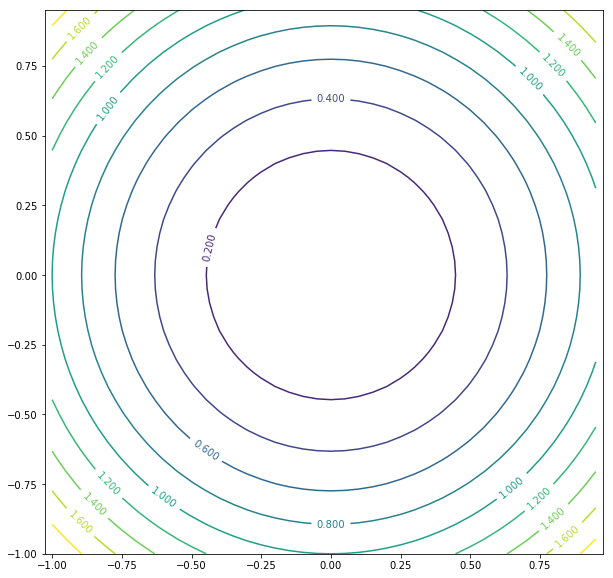

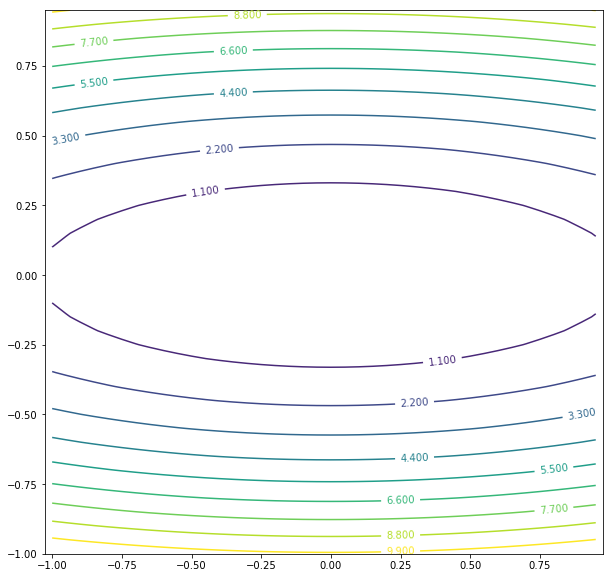

In [21]:
def func0(x):
    return x[0]*x[0]+x[1]*x[1]

def func1(x):
    return x[0]*x[0]+10*x[1]*x[1]

X0 = np.arange(-1,1,0.05)
X1 = np.arange(-1,1,0.05)
#levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func0,X0,X1)
plot_contours_func(func1,X0,X1)

#Hessian matrices are:
#
#
# Hf0 = [2 0; 0 2]    Hf1 = [2 0; 0 10]
#
#None of the hessian matrices depend on x

#The first one is well conditioned because it looks like a circular crater and the conditioning ratio is just 1
#The second one is not well conditioned because the conditioning ratio is larger than 1, in fact it is 5

Interestingly, changing the basis vectors (that is, changing the coordinates system) used to describe our function, changes its conditioning. Recall old memories of linear algebra: if you change the coordinate systems by moving from the canonical basis to the basis formed by the eigen-vectors of the Hessian matrix, then, locally, you get a perfect conditioning of $1$.<br>
<br>
So, locally in $x$, for a convex function, there exists a basis in which the function is well-conditioned and we would prefer to express the gradient in this basis in order to define a descent direction. It so happens (as said in the previous paragraph) that the basis-change matrix for such a change of coordinates is precisely the Hessian in $x$.<br>
<br>
The idea of the Conjugate Gradients method is to take successive descent directions that, instead of being orthogonal to each other in the standard coordinate system ($d_k^Td_{k+1} = 0$) are orthogonal to each other in the basis spanned by the columns of the Hessian $H$ in $x$, that is $d_k^THd_{k+1} = 0$.<br>
<br>
Such descent directions are said to be $H$-conjugate. The property of the Conjugate Gradients method is that it adapts to the local shape of the function. One can prove that by taking successive conjugate descent directions, one finally reaches the function's minimum. In practice, we can expect the Conjugate Gradients method to converge faster than plain gradient descent precisely because it avoids the "bouncing phenomenon" on the function's contour lines.<br>
<br>
To simplify the notations, from now on, we shall write $g_k = \nabla_x f(x_k)$ the function's gradient in point $x_k$.<br>
<br>
In practice, one wants to avoid computing the Hessian at each step to find the next descent direction. Because the sequence of gradients generated by line search are orthogonal to each other, finding the current descent direction $d_k$ that is $H$-conjugate to all previous descent directions, can actually be simplified to an iterative formula that only requires the knowledge of the current gradient $g_k$ and the previous descent direction $d_{k-1}$.<br>
<br>
In the case of quadratic functions (constant Hessian), the consecutive descent directions are generated by:
$$d_{k} = -g_k + \frac{\left(g_k\right)^T g_k}{(g_{k-1})^Tg_{k-1}} d_{k-1}$$

In the general case, Conjugate Gradients methods incrementally construct the sequence of descent directions using the Fletcher-Reeves or the Polak-Ribière formula. The later is the most commonly used one:
$$d_{k} = -g_k + \frac{\left(g_k\right)^T \left(g_k - g_{k-1} \right)}{(g_{k-1})^Tg_{k-1}} d_{k-1}$$
<br>
Recall that as previously, in a Conjugate Gradient method, the step-size is found by line search.<br>
<br>
Implementing a Conjugate Gradients method can be a little tedious and we won't have the time during this class to do it. However, `scipy.optimize` provides a [`fmin_cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html) function (which is actually equivalent to calling the function [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) with the argument `method='CG'`). Run the code below to see the descent performed by the CG method.

Optimization terminated successfully.
         Current function value: 0.199617
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20
[[-5.         -4.        ]
 [-4.85106719 -3.00104103]
 [-4.26824781 -2.2833877 ]
 [-2.18545591 -1.86319985]
 [-2.0772997  -1.64505431]
 [-2.43970814 -1.41815763]
 [-3.07050204 -1.74048893]
 [-3.06989534 -1.75188894]
 [-2.98876278 -1.7442493 ]
 [-2.98163825 -1.72122565]
 [-2.98116114 -1.72117362]]


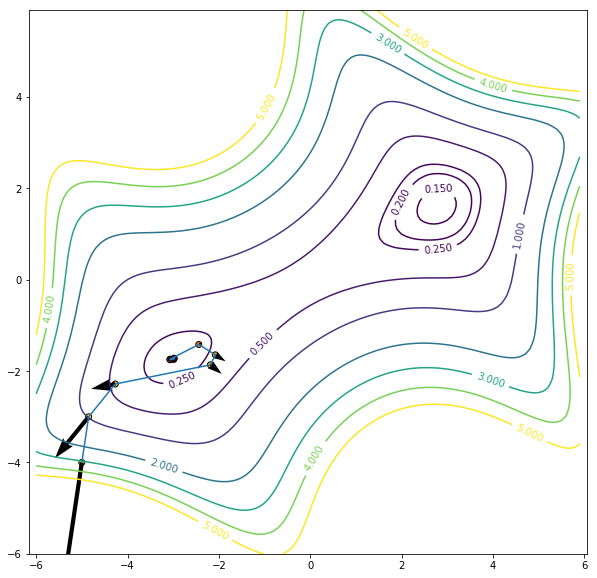

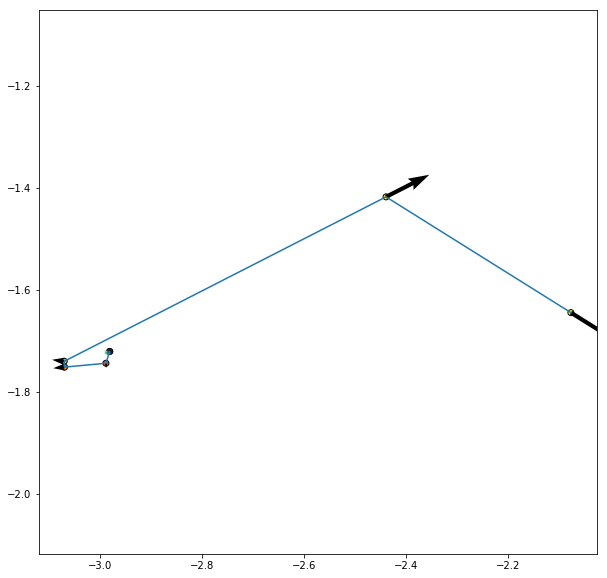

In [22]:
x0 = np.array([-5,-4])
res = sopt.fmin_cg(func, x0, fprime=func_der, retall=True, disp=True)
xopt = res[0]
steps = np.array(res[1])

print(steps)
X0 = np.arange(-6,6,0.1)
X1 = np.arange(-6,6,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func,X0,X1,levels=levels,xp=steps.T,plot_line=True,add_levels=False,f_der=func_der)
X0 = np.arange(-2.99,-2.98,0.001)
X1 = np.arange(-1.726,-1.720,0.001)
plot_contours_func(func,X0,X1,xp=steps[4:,:].T,plot_line=True,add_levels=False,f_der=func_der)

Did you notive something unexpected between the 3rd and 4th point?

Yes indeed! It seems the line search procedure did not really find a minimum and went way too far. Actually, it seems to happen also between the 1st and 2nd point, where, this time it did not go as far as expected. That's because [`fmin_cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html) performs the line search using [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions), which define stopping conditions for performing *inexact line search*. Inexact line search methods provide an efficient way of computing an acceptable step length $\alpha$ that reduces the objective function 'sufficiently', rather than minimizing the objective function over $\alpha\in \mathbb{B}^+$ exactly. So it is simply a matter of tradeoff between computational time and line search accuracy.

<div class="alert alert-warning">**Exercice:** Given all the experiments carried out in this section, with the same function and the same initialization of the search, fill the "number of steps before convergence" column in the table below.
</div>

| Algorithm                              | Number of steps before convergence |
|----------------------------------------|------------------------------------|
| Gradient descent with fixed step sizes | $\sim30$                           |
| Gradient descent with line search      | $10$                               |
| Conjugate gradients with line search   | $10$                                |

<div class="alert alert-warning">**Exercice:**
How many steps does it take to a conjugate gradients method to converge on the quadratic, ill-conditioned $f_1(x_0,x_1) = x_0^2+10x_1^2$ (`func1`) function?
</div>

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
[[ -8.00000000e-01  -7.00000000e-01]
 [ -7.19060820e-01   8.21782903e-03]
 [  9.15483134e-10  -8.03993922e-09]]


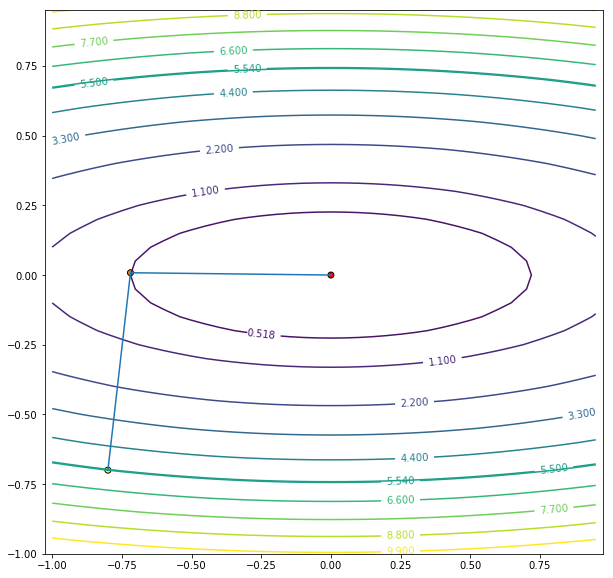

In [26]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

x0 = np.array([-0.8,-0.7])
res = sopt.fmin_cg(func1, x0, retall=True, disp=True)
xopt = res[0]
steps = np.array(res[1])

print(steps)
X0 = np.arange(-1,1,0.05)
X1 = np.arange(-1,1,0.05)
plot_contours_func(func1,X0,X1,xp=steps.T,plot_line=True,add_levels=True)


<div class="alert alert-info">
Let's wrap everything up. In this section we have focused on gradient descent methods. We have seen that:
<ol>
<li> Descent methods define a sequence $x_{k+1} = x_k + \alpha_k d_k$, where $d_k$ is a descent direction and $\alpha_k$ is the step size.
<li> The opposite of the gradient gives a descent direction.
<li> The step size needs to be adapted to guarantee convergence. For this, we introduced line search and its properties.
<li> The conjugate gradients method takes descent directions that account for the local shape (convexity, conditioning) of the function and converge faster.
</ol>
</div>

# 4. <a id="part4"></a>Constrained optimization
[Link to top](#top)

In the previous section, we have considered problems of the form $\min_x f(x)$. But in the aircraft design example of section 2, we saw that the general form of an optimization problem is rather:
\begin{gather}
\min_x f(x)\\
h(x) \leq 0\\
g(x) = 0
\end{gather}

It seems the gradient descent methods introduced in the previous section cannot take constraints into account and thus cannot cope with general optimization problems. We won't detail any theory in this section concerning how we can solve such problems; sections 6 and 7 (both optional for this class) are here to satisfy your curiosity in that matter. Instead, we will simply give an example of how these problems can be solved *approximately* using the [`scipy.optimize.fmin_slsqp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html) function.

We shall keep the same example function as in the previous section and add two constraints:
\begin{gather}
x_1 \leq -0.8 x_0\\
x_1 \leq 2-0.9 x_0^2
\end{gather}

In the code below we shade out in blue the area forbidden by the first constraint and in orange the area forbidden by the second.

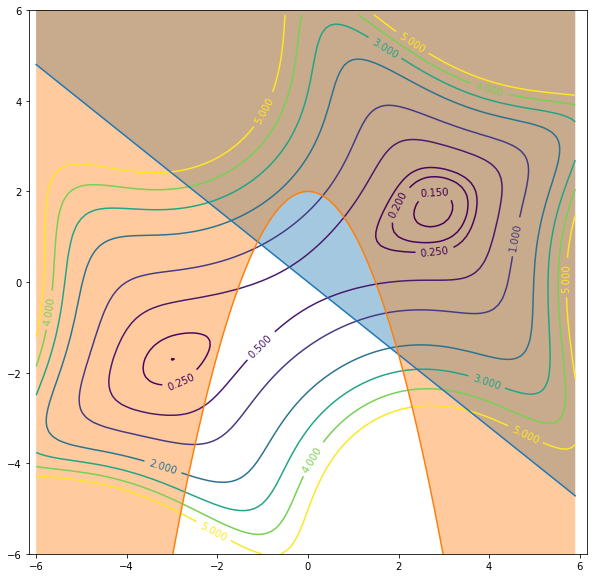

In [27]:
X0 = np.arange(-6.,6.,0.1)
X1 = np.arange(-6.,6.,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func, X0, X1, levels=levels)

# constraint 1
a  = 0.
a0 = 0.8
a1 = 1.
H = -(a+a0*X0)/a1
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)

# constaint 2
b  = -2.
b0 = 0.9
b1 = 1.
H = -(b+b0*X0*X0)/b1
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)

plt.xlim([-6.,6.])
plt.ylim([-6.,6.]);

Our inequality constraint function $h$ is thus:
$$h(x) = \left(\begin{array}{c}0.8x_0 + x_1\\ 0.9x_0^2 + x_1-2\end{array}\right)\textrm{with }h(x)\leq 0$$
And there is no equality constraint function $g$.

Note that [`scipy.optimize.fmin_slsqp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html) adopts the convention of positive constraints $h(x)\geq 0$.

In [28]:
def ineq_constr(x):
    return -np.array([a0*x[0]+a1*x[1]+a, b0*x[0]*x[0]+b1*x[1]+b])

def ineq_constr_der(x):
    return -np.array([[a0, a1],[b0*x[0], b1]])

x0 = np.array([-5,-4])
x0 = np.array([0,-2])
X = [x0]

def store_x(x):
    X.append(np.copy(x))
    return

res = sopt.fmin_slsqp(func, x0, f_ieqcons=ineq_constr, 
                      fprime=func_der, fprime_ieqcons=ineq_constr_der, 
                      disp=2, iter=12, callback=store_x)
X = np.array(X)

  NIT    FC           OBJFUN            GNORM
    1     1     1.532087E+00     1.345729E+00
    2     2     4.292587E-01     3.099720E-01
    3     3     3.608999E-01     7.779763E-02
    4     4     3.536249E-01     8.389924E-02
    5     5     2.931189E-01     1.444890E-01
    6     6     3.072952E-01     9.818702E-02
    7     8     2.764413E-01     1.074722E-01
    8    11     2.730332E-01     1.200424E-01
    9    13     2.726111E-01     1.498179E-01
   10    14     2.812383E-01     1.952143E-01
   11    25     2.812383E-01     1.952143E-01
   12    36     2.812383E-01     1.952143E-01
   13    47     2.812383E-01     1.952143E-01
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.28123833174634255
            Iterations: 13
            Function evaluations: 47
            Gradient evaluations: 13


[-1.9798218  -1.52076506]


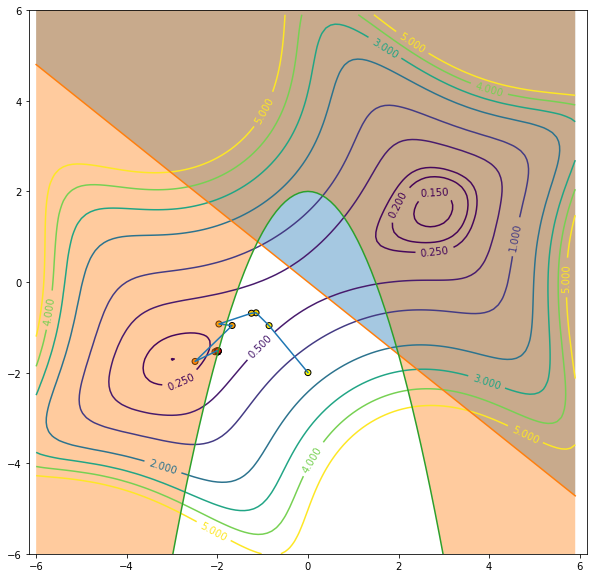

In [29]:
# Plot the solution

X0 = np.arange(-6.,6.,0.1)
X1 = np.arange(-6.,6.,0.1)
levels = np.array([0.15, 0.2, 0.25, 0.5, 1., 2., 3., 4., 5.])
plot_contours_func(func, X0, X1, xp=X.T, plot_line=True, levels=levels, add_levels=False)

# constraint 1
H = -(a+a0*X0)/a1
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)

# constaint 2
H = -(b+b0*X0*X0)/b1
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)

plt.xlim([-6.,6.])
plt.ylim([-6.,6.])

print(res)

# 5. <a id="part5"></a>Second order methods
[Link to top](#top)

Section 3 introduced gradient descent methods and their different flavours, pitfalls and a first call to the `scipy.optimize` functions. Gradient methods feature a great simplicity in exchange for a slow convergence (a large number of steps required to reach an optimum).<br>

We progressively introduced a little complexity to solve the issues we encountered (line search for step size and conjugate gradients for descent directions) but the overall computation remains rather simple. In the trade-off between single-step computation complexity and convergence rate, we shall now take a look at the opposite extreme: Newton's method, which is arguably the most complex but also the fastest converging gradient method.<br>
<br>
The intuition behind Newton's method consists in searching for points $x_k$ that are likely to cancel $\nabla_x f(x_k)$ (instead of the previous search for points that decrease the value of $f(x_k)$). For simplicity, let's write $F(x) = \nabla_x f(x)$. Then, the first order approximation of $F$ is:
$$F(x+d) = F(x) + \nabla_x F(x)\cdot d + o(d)$$
In order to have $F(x+d)=0$, one should take $d = -\left[\nabla_x F(x)\right]^{-1}F(x)$. Replacing $F$ by $\nabla_x f(x)$ we get:
$$d = -\left[\nabla_x^2 f(x)\right]^{-1}\nabla_x f(x)$$
<br>
This defines Newton's method: $x_{k+1} = x_k - \left[\nabla_x^2 f(x_k)\right]^{-1}\nabla_x f(x_k)$<br>
<br>
Let's simplify the notation again by writing $H_k = \nabla_x^2 f(x_k)$ and $g_k=\nabla_x f(x_k)$. So Newton's method is defined by:  $x_{k+1} = x_k - (H_k)^{-1}g_k$<br>
<br>
Although this method seems appealing (it converges to the global minimum in a single step for quadratic functions!), computing and inverting the Hessian at each step is quite cumbersome. Recall that the general complexity for inverting an $n\times n$ matrix (via Gaussian elimination of Cholesky factorization for instance) is $O(n^3)$. For large values of $n$ (for optimization problems with lots of variables), this might prove too costly, especially if we have to do it in each $x_k$. There are two main alternatives to this:
<ul>
<li> Compute $d_k$ as an approximate version of $-(H_k)^{-1}g_k$
<li> Compute $B_k$ as an approximation of $(H_k)^{-1}$ and set $d_k = -B_k g_k$
</ul>
<br>
The first method is known as the *Truncated Newton method* or the *Newton - Conjugate Gradient method*. It works by remarking that $d_k = -(H_k)^{-1}g_k$ is the optimal solution of the minimization problem:
$$\min \phi(d) = \frac{1}{2} d^T H_k d - (g_k)^T d$$
The gradient of $\phi$ is easy to estimate:
$$\nabla_x \phi(d) = H_k d - g_k$$
So we can apply a Conjugate Gradients method to find a close approximation to $d$, given the Hessian $H_k$, without having to invert it. Note that this method still requires to compute $H_k$ but avoids the costly matrix inversion.<br>
<br>
In `scipy.optimize`, this is implemented in the [`fmin_ncg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_ncg.html) function (or equivalently, by calling [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) with the `method='Newton-CG'` argument). You can also check the [`fmin_tnc`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_tnc.html) function for an alternate version.
<div class="alert alert-warning">**Exercice:** Your turn to play. Use the `fmin_ncg` function to find the minimum of `func`. You can adapt what was done with conjugate gradients in the previous exercice (use the documentation!). The function's Hessian is provided below.
</div>

In [ ]:
def func_hess(x):
    a = np.pi/6.
    c = np.cos(a)
    s = np.sin(a)
    xx = c*x[0]+s*x[1]
    yy = -s*x[0]+c*x[1]
    p = np.poly1d([0.019217057452351031, 0.013158736688148412, -0.42345571095569301, -0.24761472187941180, 4.])
    pp = np.polyder(p)
    ppp = np.polyder(pp)
    q = np.poly1d([0.1, 0., 0.1])
    qq = np.polyder(q)
    qqq = np.polyder(qq)
    h_xx = c*c*ppp(xx)*q(yy) - 2.*c*s*qq(yy)*pp(xx) + s*s*qqq(yy)*p(xx)
    h_xy = c*s*ppp(xx)*q(yy) + (c*c-s*s)*qq(yy)*pp(xx) - s*c*qqq(yy)*p(xx)
    h_yy = s*s*ppp(xx)*q(yy) + 2.*c*s*qq(yy)*pp(xx) + c*c*qqq(yy)*p(xx)
    return np.array([[h_xx,h_xy],[h_xy,h_yy]])

In [ ]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


The second family of methods (the one that computes $B_k$ as an approximation of $\left[\nabla^2 f(x_k)\right]^{-1}$ and set $d_k = -B_k g_k$) is known as *quasi-Newton methods*. The intuition behind quasi-Newton methods relies on the following remark:
$$\nabla f(x_{k+1}) - \nabla f(x_k) \approx \nabla^2 f(x_{k+1}) \left(x_{k+1}-x_k\right)$$

Or with the simplified notations: $g_{k+1}-g_k \approx H_{k+1} \left(x_{k+1}-x_k\right)$. <br>
Suppose that $H=\nabla^2 f(x)$ does not vary too much with $x$. Suppose also that one has kept track of $n$ independent vectors $d_k = x_{k+1}-x_k$ and $n$ other independent vectors $\sigma_k = g_{k+1} - g_k$. Then it becomes possible to use those vectors to approximate $H=\nabla^2 f(x)$ and, more usefully, $H^{-1}=\left[\nabla^2 f(x)\right]^{-1}$:
$$H=\nabla^2 f(x) \approx \left[ \sigma_0 \ldots \sigma_{n-1} \right]\left[ d_0 \ldots d_{n-1} \right]^{-1}$$
$$H^{-1}=\left[\nabla^2 f(x)\right]^{-1} \approx B=\left[ d_0 \ldots d_{n-1} \right]\left[ \sigma_0 \ldots \sigma_{n-1} \right]^{-1}$$
<br>
The key here is that this operation can be performed incrementally, that is one can simply update the current value of $B$ when a new pair $(d,\sigma)$ is obtained.<br>
<br>
The most well-known quasi-Newton method is called BFGS (from the author's names: Broyden, Fletcher, Goldfarb, Shanno). The update formula for BFGS, given a new $(d,\sigma)$ is:
$$B \leftarrow B + \frac{\left(d^T\sigma + \sigma^TB\sigma\right)\left(dd^T\right)}{\left(d^T\sigma\right)^2} - \frac{B\sigma d^T+d\sigma^TB}{d^T\sigma}$$

The main advantage of quasi-Newton methods is that they converge fast without requiring neither the computation of the Hessian matrix, not its inversion. On the other hand, their main drawback is that one has to compute and store $B_k$ at each iteration.<br>
<br>
Again, `scipy.optimize` provide a function for BFGS: [`fmin_bfgs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html) (or [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) with the `method='BFGS'` option).<br>
<br>
Note that BFGS stores big matrices in memory. A so-called "limited memory" version of BFGS, called L-BFGS is available under the [`fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html) function (or [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) with the `method=L-BFGS-B` option). Today, L-BFGS is considered the method of choice for non-linear optimization in a wide variety of applications.
<div class="alert alert-warning">**Exercice:** Your turn to play. Use the `fmin_bfgs` function to find the minimum of `funcx`.
</div>

In [ ]:
# %load solutions/code7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


# 6. <a id="part6"></a>Introduction to the Karush-Kuhn-Tucker theory
[Link to top](#top)

## 6.1 <a id="part6.1"></a>A graphical introduction

Let's take a step back and reconsider our original problem. We wrote in the introduction that we wanted to solve:
$$\min_x f(x)$$
$$\textrm{under the constraints }h(x)\leq 0$$
So far we have only done unconstrained optimization. Let's take a look into taking these constraints into account.

This section aims at gently introducing the Karush-Kuhn-Tucker theorem for constrained optimization, from an intuitive and graphical perspective.<br>
There is no code for you to write here, just follow the reasoning. The final goal of this part is to give you an intuition as to where the Lagrangian formulation comes from and how you can naturally come up with it.<br>
<br>
Let's consider a new function $f(x_0,x_1)= x_0^2 + x_0x_1+ 2x_1^2$ that we want to minimize.<br>
It is easy to see that the minimum of $f$ without constraints is at $(x_0,x_1)=(0,0)$ and that this minimum is global. <br>
We now add the constraint that $h(x_0,x_1) = 0.8x_0+x_1-a\leq 0$, $a$ being a scalar parameter that we will play with.<br>
The Python functions returning $f(x)$, $\nabla_x f(x)$, $\nabla_x^2 f(x)$, $h(x)$, $\nabla_x h(x)$, and $\nabla_x^2 h(x)$ are provided below.<br>
Run the code below to plot the contour lines of the function and display the admissible domain (for a value of $a=-5$). The shaded area is the forbidden one.


In [ ]:
def f(x):
    return x[0]**2 + x[0]*x[1] +2.*x[1]**2
def f_der(x):
    return np.array([2.*x[0] + x[1], x[0]+4.*x[1]]).T
def f_hess(x):
    return np.array([[2., 1.],[1., 4.]])

a = -5.
def h(x):
    return .8*x[0]+x[1]-a
def h_der(x):
    return np.array([.8, 1]).T
def h_hess(x):
    return np.zeros((2,2))

def h_plot(x):
    return a-.8*x

X0 = np.arange(-10.,10.,0.1)
X1 = np.arange(-10.,10.,0.1)
plot_contours_func(f,X0,X1)
H = h_plot(X0)
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)
plt.xlim([-10.,9.9])
plt.ylim([-10.,9.9]);

Let's change the value of the parameter $a$ in the example code above.
<ul>
<li> For $a=6$ where is the minimum of $f(x)$ such that $h(x)\leq 0$?
<li> For $a=-5$ where is the minimum of $f(x)$ such that $h(x)\leq 0$?
<li> For $a=0$    where is the minimum of $f(x)$ such that $h(x)\leq 0$?
</ul>

From these observations, one can generalize that if the global minimum $x^*$ of $f$ is *inside* the admissible domain defined by the constraints, then the minimum of $f$ under these constraints is still found in $x^*$.<br>
<br>
The question now is: how can we characterize the minimum of $f$ under constraints, when the constraints exclude $x^*$ from the admissible domain?<br>
<br>
Let's work with the $a=-5$ case and let's try to perform a single step of gradient descent with line search from the admissible point $(2,-8)$.

In [ ]:
x0 = np.array([2.,-8.])

# Gradient descent with line search
d0 = -f_der(x0) / np.linalg.norm(f_der(x0))
def g0(alpha):
    return f(x0 + alpha*d0)
res = sopt.minimize_scalar(g0)
alpha0 = res.x
x1 = x0 + alpha0*d0

# Display
X = np.array([x0,x1])
X0 = np.arange(-1.,10.,0.1)
X1 = np.arange(-10.,1.,0.1)
plot_contours_func(f,X0,X1,xp=X.T,plot_line=True,f_der=f_der,add_levels=False)
H = h_plot(X0)
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)
plt.xlim([-1.,9.9])
plt.ylim([-10.,0.9]);

We notice that the new point $x_1$ is outside of the admissible domain. We should have seen this coming. In order to avoid leaving the admissible domain, we can change the line search method so that it stops when hitting the constraint. Let's do that by hand for now. Let $x_{inter} = x_0 + \alpha_{inter}d_0$ be the intersection of the constraint and the descent line. $\alpha_{inter}$ is thus a solution to the equation $h(x_0+\alpha d_0)=0$. We could solve that by hand, but let's use the [`brentq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) function of `scipy.optimize` that finds roots to scalar functions, just to practice.

In [ ]:
#The intersection between the gradient's line and the constraint
def g00(alpha):
    return h(x0+alpha*d0)
alpha_inter = sopt.brentq(g00,0.,10.)

Now let's start again from $x_0$ by imposing an upper bound on $\alpha$.

In [ ]:
# Line search with the upper bound on alpha
d0 = -f_der(x0) / np.linalg.norm(f_der(x0))
def g0(alpha):
    return f(x0 + alpha*d0)
res = sopt.minimize_scalar(g0,bounds=[0,alpha_inter],method='Bounded')
alpha0 = res.x
x1 = x0 + alpha0*d0

# Display
X = np.array([x0,x1])
X0 = np.arange(1.,4.,0.1)
X1 = np.arange(-9.,-6.,0.1)
plot_contours_func(f,X0,X1,xp=X.T,plot_line=True,f_der=f_der,add_levels=False)
H = h_plot(X0)
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)
plt.xlim([1.,3.9])
plt.ylim([-9.,-6.1]);

So now we've hit the constraint and the new gradient would pull us out of the admissible domain. However, there must be some component of this gradient that allows us to move downwards by following the constraint.<br>
Let's decompose this gradient in $x_1$ into a component that is orthogonal to the constraint (thus collinear with the constraint's gradient) and the remainder $d_1$ (that is thus parallel to the constraint).<br>
By following $d_1$ we stay within the admissible domain and we can reach a new minimum via line search.

In [ ]:
# Remove the component of the descent direction that is collinear to gradient
u_grad = h_der(x1) / np.linalg.norm(h_der(x1))
d = -f_der(x1)
d1 = d - np.dot(d,u_grad)*u_grad

# Perform line search along the d1 admissible direction
# Note that since the constraint is a line, we do not fear hitting another constraint, 
# so we don't have to bound the search of alpha: 
# we know that we will stay in the admissible domain by moving along d1.
d1 = d1 / np.linalg.norm(d1)
def g1(alpha):
    return f(x1 + alpha*d1)
res = sopt.minimize_scalar(g1)
alpha1 = res.x
x2 = x1 + alpha1*d1

# Display
X = np.array([x0,x1,x2])
X0 = np.arange(-5.,5.,0.1)
X1 = np.arange(-10.,0.,0.1)
plot_contours_func(f,X0,X1,xp=X.T,plot_line=True,f_der=f_der,add_levels=False)
H = h_plot(X0)
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)
plt.quiver(x1[0], x1[1], -d1[0], -d1[1])
print(x1)
print(d1)
plt.xlim([-5.,4.9])
plt.ylim([-10.,-0.1])

# Display with zoom out
X0 = np.arange(-10.,10.,0.1)
X1 = np.arange(-10.,10.,0.1)
plot_contours_func(f,X0,X1,xp=X.T,plot_line=True,f_der=f_der,add_levels=True)
H = h_plot(X0)
plt.plot(X0,H)
plt.fill_between(X0,H,10.*np.ones(X0.shape[0]), alpha=0.4)
plt.quiver(x1[0], x1[1], -d1[0], -d1[1])
plt.xlim([-10.,9.9])
plt.ylim([-10.,9.9]);

So we have found a new point $x_2$.<br>
<br>
Now let's consider the gradient $\nabla_x f(x_2)$ and repeat the previous step. We want to decompose this gradient in two components: one collinear to the constraint's gradient $\nabla_x h(x_2)$ and the other one orthogonal to $\nabla_x h(x_2)$.<br>
<br>
But, in this example, the gradient of the constraint is constant. And, since $x_2$ is the minimum of the line search along the constraint, $\nabla_x f(x_2)$ is collinear to $\nabla_x h(x_2)$. In other words, there is no direction that would decrease the function $f$ while letting us remain in the admissible domain.<br>
<br>
Consequently, we have found the minimum of $f$ under the constraint $h(x) \leq 0$.<br>
<br>
Let's slightly refine that last statement. In $x_2$ we actually know two things:
- We know that $\nabla_x f(x_2)$ is collinear to $\nabla_x h(x_2)$.
- We also know that $\nabla_x f(x_2)$ points in the opposite direction as $\nabla_x h(x_2)$.<br>
So, actually, we know that there exists a __positive__ scalar value $\lambda$ such that $\nabla_x f(x_2) = - \lambda \nabla_x h(x_2)$.<br>

Now comes the generalisation. The key property that we have highlighted here is that at the minimum *under constraints*, $\nabla_x f(x)$ is collinear to $\nabla_x h(x)$ and points in the opposite direction. Consequently, finding the minimum under constraints results in finding a point $x$ such that:
$$\exists \lambda\in \mathbb{R}^+ \textrm{ s.t. }\nabla_x f(x)=-\lambda\nabla_x h(x)$$
Note that there might be many points for which this condition holds. That does not make them minimas, but among all these points, one is the minimum under constraints.
Let us rephrase this last line:
$$\exists \lambda\in \mathbb{R}^+ \textrm{ s.t. }\nabla_x \left[f(x)+\lambda h(x)\right]=0$$
So, by writing $\mathcal{L}(x,\lambda) = f(x) + \lambda h(x)$, the minimum under constraints of our function is characterized by:
$$\exists \lambda\in \mathbb{R}^+ \textrm{ s.t. }\nabla_x \mathcal{L}(x,\lambda) = 0$$
The linear combination $\mathcal{L}$ of $f$ and $h$ is called the **Lagrangian** of the optimization problem.<br>
<br>
So now you can generalize to several inequality constraints $h_1$, $h_2$, etc. The same reasoning holds also for equality constraints. And in the end, here is what you should remember (in plain English):<br>
<div class="alert alert-success">
Given an optimization problem with $f$ the objective function and $h_i$ the various inequality constraints. At a minimum under constraints $x^*$, the gradient of the objective function can be expressed as a linear combination of the gradients of the constraints.</div>
Moreover, for non-saturated constraints, their coefficient in this linear combination will be zero.<br>
<br>
In a more formal notation:
$$x^*\textrm{ is a local minimum }\Rightarrow \exists \lambda\in {\mathbb{R}^+}^p \textrm{ s.t. }\nabla_x \mathcal{L}(x^*,\lambda) = 0$$
So the key intuition here is that searching for a minimum of $f$ under constraints $h$ will require (at least) to find a minimum of $\mathcal{L}$ with respect to $x$.<br>
<br>
That same intuition is how you introduce the notion of duality in non-linear programming, but that is beyond the scope of this class.<br>
<br>

# 6.2 <a id="part6.2"></a>The Lagrangian and Karush-Kuhn-Tucker's conditions

From this introduction of the Lagrangian, we can derive the Karush-Kuhn-Tucker conditions that defines rigorously the properties of a function's minimum under constraints.

<div class="alert alert-success">**Lagrangian of an optimization problem**<br>
Given an optimization problem $\mathcal{P}$ ormulated as:
$$\mathcal{P}: \left\{\begin{array}{l}
\min_x f(x)\\
h(x) \leq 0\\
g(x) = 0
\end{array}\right.$$
The problem's Lagrangian is defined by:
$$\mathcal{L}(x,\lambda,\mu) = f(x) + \lambda^T g(x) + \mu^T h(x)$$
</div>

<div class="alert alert-success">**First order Karush-Kuhn-Tucker necessary optimality conditions**<br>
Given an optimization problem $\mathcal{P}$ with twice differentiable objective function and constraints:
$$\mathcal{P}: \left\{\begin{array}{l}
\min_x f(x)\\
h(x) \leq 0\\
g(x) = 0
\end{array}\right.$$
Suppose there are $q$ equality constraints and $p$ inequality constraints.<br>
<br>
Then under some regularity conditions on the constraints (also called qualification conditions), then the following *necessary condition* holds:
$$x^*\textrm{ is a local minimum of }\mathcal{P} \Rightarrow \exists (\lambda^*,\mu^*) \in \mathbb{R}^q\times{\mathbb{R}^+}^p\textrm{ such that }\left\{\begin{array}{l}
\nabla_x \mathcal{L}(x^*,\lambda^*,\mu^*) = 0\\
\nabla_\lambda \mathcal{L}(x^*,\lambda^*,\mu^*) = g(x^*) = 0\\
\forall j \in [1,p], \mu^*_j h_j(x^*) = 0
\end{array}\right.$$
</div>

<div class="alert alert-success">**Admissible directions in $x$**<br>
If, at a point $x\in\mathbb{R}^n$, a given constraint verifies $h_j(x)=0$, then this constraint is called *active* or *saturated*. Let $\mathcal{A}(x)$ the set of the active constraints indices at $x$.<br>
<br>
The set $\mathcal{D}_{x}$ of admissible directions in $x$ is the set of directions that point towards the admissible domain from $x$
$$\mathcal{D}_{x}(\Omega) = \left\{ v\in
  \mathbb{R}^n / v^T \nabla g(x) = 0 \textrm{ and } v^T \nabla h_j(x)\leq 0 \textrm{ for }j\in \mathcal{A}(x) \right\}$$

</div>

<div class="alert alert-success">**Second order Karush-Kuhn-Tucker necessary and sufficient optimality conditions**<br>
Given an optimization problem $\mathcal{P}$ with twice differentiable objective function and constraints:
$$\mathcal{P}: \left\{\begin{array}{l}
\min_x f(x)\\
h(x) \leq 0\\
g(x) = 0
\end{array}\right.$$
Suppose there are $q$ equality constraints and $p$ inequality constraints.<br>
<br>
Then under some regularity conditions on the constraints (also called qualification conditions), then the following *necessary and sufficient condition* holds:
$$x^*\textrm{ is a local minimum of }\mathcal{P} \Leftrightarrow \exists (\lambda^*,\mu^*) \in \mathbb{R}^q\times{\mathbb{R}^+}^p\textrm{ such that }\left\{\begin{array}{l}
\nabla_x \mathcal{L}(x^*,\lambda^*,\mu^*) = 0\\
\nabla_\lambda \mathcal{L}(x^*,\lambda^*,\mu^*) = g(x^*) = 0\\
\forall j \in [1,p], \mu^*_j h_j(x^*) = 0\\
\forall v\in \mathcal{D}_{x^*}\setminus\{0\}, v^T \nabla_x^2\mathcal{L}(x^*,\lambda^*,\mu^*) v > 0 
\end{array}\right.$$
</div>

Of course, this theorem would require much discussion (which you can find in the lecture notes or in any good Optimization textbook). But you have the key idea stated formally above: at a minimum under constraints, the gradient of the objective function can be expressed as a linear combination of the gradients of the constraints.

## 6.3 <a id="part6.3"></a>Analytical resolution of nonlinear programming problems using the KKT conditions

<div class="alert alert-danger">**TODO:** finish writing the discussion here with an exercice using KKT's conditions.<br>
<br>
In the meantime, students can refer to the lecture notes or the memento for additional material.
</div>

# 7. <a id="part7"></a> (Sequential) Quadratic programming
[Link to top](#top)

<div class="alert alert-danger">**TODO:** write this part.<br>
<br>
In the meantime, students can refer to the lecture notes or the memento for additional material.
</div>

# 8. Exercice
[Link to top](#top)

This is a slight variation on the [beam design problem from section 2](#part2):

<img width=300px src="img/raidisseur.png"></img>

> An aircraft design engineer comes to you and asks:

> In the design department, we usually draw plans of the plane's wings and then try out different I-beam shape factors to test if they can resist the buckling loads suffered in-flight. But we're never really sure that we have the lightest possible beam and that is a problem since the lighter our beams are, the better our plane's propulsion performance. We've heard you mathematicians can help us find the best I-beam shapes.

> The global load that can be handled by the beam can be written $\frac{\pi^2 E I}{L^2}$ where $I$ is the beam's moment of inertia $I = e\frac{h^2}{2}\left(\frac{h}{6}+b\right)$. Additionnaly, our previous calculations provide a value $P_{max}$ for the worst-case load suffered in flight.

> We cannot manufacture beams with a thickness smaller than $e_{min}$.

> There is a local buckling limit also that can be expressed as:
$$\frac{P_{max}}{S} \leq K \left(\frac{e}{h}\right)^2$$
> Where $S$ is the section's surface, and $K$ a given constant.

> Here are the constants:<br>
> $E = 75000$ MPa (Young's modulus)<br>
> $K = \frac{4\pi^2 E}{12(1-\nu^2)}$ (local buckling)<br>
> $\nu = 0.33$ (Poisson's coefficient)<br>
> $P_{max} = 5\cdot10^5$ MPa (max load)<br>

<br>
<div class="alert alert-warning">**Exercice [13 points]:**<br>
<ol>
<li> [1 point] List the decision variables
<li> [1 point] What is the problem's objective function?
<li> [2 points] What are the problem's constraints?
<li> [5 points] Using [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html), write a program that solves this optimization problem.
<li> [2 points] Discuss the results
<li> [2 points] What happens to the solution if you neglect the local buckling constraint?
</ol>
</div>


Names of the students: Kartik VENKATRAMAN, Pablo RODRIGUEZ OTERO


In [6]:
# Names of the students: Kartik VENKATRAMAN, Pablo RODRIGUEZ OTERO


# 1) the decision variables are e, h, b
# 2) For this problem the length of the beam is constant so in order to minimize the mass it is enough to minimize 
#    the section's surface. The objective function is:  f(x)=e(2b+h)
# 3) There are three optimisation constraints:
#                  -Pmax/(2*b*e+e*h)+K*(e/h)**2 >/= 0
#                  -Pmax+(np.pi**2*E)/(L**2)*e*(h**2)/2*(h/6+b) >/= 0
#                  -emin+e >/= 0
#
# 4) Code:

#Importing the libraries
import numpy as np
import scipy.optimize as sopt
import math

#Defining the constants
E = 75000 #N/mm^2
v = 0.33
K = 4*np.pi**2*E/(12*(1-v**2))
Pmax = 5e5 #N
emin = 1 #mm
L = 503 #mm

def obfun(x): #Defining of the objective function
    e = x[0] 
    h = x[1]
    b = x[2]
    return 2*b*e+e*h

def Dobfun(x): # Defining the derivative of objective function
    e = x[0] 
    h = x[1]
    b = x[2]
    return np.array([2*b+h,e,2*e])

def inecon(x): # Defining the inequality constraints >/=0
    e = x[0] 
    h = x[1]
    b = x[2]
    return np.array([-Pmax/(2*b*e+e*h)+K*(e/h)**2,
                     -Pmax+(np.pi**2*E)/(L**2)*e*(h**2)/2*(h/6+b),
                     -emin+e])

def Dinecon(x): # Defining the gradient of the vectors containing the constraints
    e = x[0] 
    h = x[1]
    b = x[2]
    return np.array([#[(2*b+h)*K*3*e**2/h**2,
                     #-2/h**3*(K*2*b*e**3+h*e**3*K),
                     #K*2*e**3/h**2],
                     [Pmax/((2*b+h)*e**2)+2*K*e/h**2,
                     Pmax/(e*(2*b+h)**2)-(2*K*e**2)/(h**3),
                     2*Pmax/(e*(2*b+h)**2)],
                      [(np.pi**2*E)/(L**2*2)*h**2*(h/6+b),
                       (np.pi**2*E)/(L**2*2)*e*(h**2/2+2*h*b),
                       (np.pi**2*E)/(L**2*2)*e*h**2],
                      [1,0,0]])


def store_x(x):  # List to store the results
    X.append(np.copy(x))
    return

# Three vectors are defined containing the set of initial conditions
ev = np.linspace(1,10,10)
hv = np.linspace(1,10,10)
bv = np.linspace(1,10,10)

#Empty list to save the resutls
results = []

#Iteration loop to find the solutions for the set of initial conditions
for i in range(10):
    for j in range(10):
        for k in range(10):
            x0 = np.array([ev[int(i)],hv[int(j)],bv[int(k)]])
            X = [x0]
            res = sopt.fmin_slsqp(obfun, x0, f_ieqcons=inecon,
                                  bounds=[(0,10000),(0,10000),(0,10000)],
                                  fprime=Dobfun, fprime_ieqcons=Dinecon, 
                                  disp=2, iter=100, callback=store_x)
            X = np.array(X)
            res
            
            #Results for each vector of initial conditions are appended to
            #the defined empty vector called results
            results.append([res[0],res[1],res[2]])



  NIT    FC           OBJFUN            GNORM
    1     1     3.000000E+00     3.741657E+00
    2     2     2.053844E+00     3.093662E+00
    3     4     2.028910E+00     3.132588E+00
    4     5     2.027887E+00     3.146194E+00
    5     6     2.027872E+00     3.144472E+00
    6     7     2.027872E+00     3.144514E+00
    7    18     2.027872E+00     3.144514E+00
   12    29     2.027872E+00     3.144514E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.027871500714533
            Iterations: 12
            Function evaluations: 29
            Gradient evaluations: 8
  NIT    FC           OBJFUN            GNORM
    1     1     5.000000E+00     5.477226E+00
    2     2     3.017407E+00     3.755628E+00
    3     3     1.994071E+00     3.276892E+00
    4     4     1.805708E+00     2.979844E+00
    5     5     1.804096E+00     2.962774E+00
    6     6     1.804011E+00     2.958858E+00
    7    17     1.804011E+00     2.958858E+00
    8    

/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/home/vacat/x.olive/students/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_sca


   12    11     4.824341E+04     2.787051E+03
   13    12     4.721711E+04     2.763731E+03
   14    13     4.416304E+04     2.627720E+03
   15    14     3.028797E+04     1.967768E+03
   16    15     1.898799E+04     1.382615E+03
   17    16     1.197295E+04     9.684629E+02
   19    17     1.048077E+04     8.760975E+02
   20    18     9.712122E+03     8.452972E+02
   21    19     8.537096E+03     7.658093E+02
   22    20     5.373902E+03     5.367663E+02
   23    21     3.353430E+03     3.789742E+02
   24    22     2.113595E+03     2.663938E+02
   25    23     1.373688E+03     1.884583E+02
   26    24     0.000000E+00     5.589062E+00
   27    35              NAN              NAN
   28    46              NAN              NAN
   29    57              NAN              NAN
   30    68              NAN              NAN
   31    79              NAN              NAN
   32    90              NAN              NAN
   33   101              NAN              NAN
   34   112              NAN     

   25    23     3.590609E+02     8.233797E+01
   27    24     3.594528E+02     8.278083E+01
   28    25     3.594520E+02     8.278348E+01
   29    26     3.594519E+02     8.279699E+01
   30    27     3.594519E+02     8.280990E+01
   31    28     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192561218244
            Iterations: 31
            Function evaluations: 28
            Gradient evaluations: 28
  NIT    FC           OBJFUN            GNORM
    1     1     1.800000E+01     1.813836E+01
    2     2     3.701741E+06     5.121471E+03
    3     3     1.515997E+06     3.207753E+03
    4     4     4.980183E+05     1.498808E+03
    6     5     1.624057E+05     9.611091E+02
    7     6     5.330903E+04     7.725847E+02
    8     7     1.767869E+04     6.647977E+02
    9     8     8.450296E+03     6.316904E+02
   11     9     7.432416E+03     6.274474E+02
   12    10     6.257575E+03     6.096340E+02
   13  

   97   906              NAN              NAN
   98   917              NAN              NAN
   99   928              NAN              NAN
  100   939              NAN              NAN
  101   950              NAN              NAN
Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 101
            Function evaluations: 950
            Gradient evaluations: 100
  NIT    FC           OBJFUN            GNORM
    1     1     2.500000E+01     2.509980E+01
    2     2     7.176815E+05     2.475692E+03
    3     3     3.152353E+05     1.658986E+03
    4     4     1.032764E+05     7.122928E+02
    5     5     4.109458E+04     4.405259E+02
    7     6     1.866843E+04     3.671610E+02
    8     7     6.168196E+03     3.066807E+02
    9     8     2.641301E+03     2.783967E+02
   10     9     2.144329E+03     2.728729E+02
   11    10     1.976346E+03     2.561545E+02
   12    11     1.255103E+03     1.808622E+02
   13    12     7.967800E+02    

   10    10     3.967639E+02     7.693388E+01
   11    11     3.595852E+02     7.946425E+01
   12    12     3.602845E+02     8.003755E+01
   13    13     3.602009E+02     8.017875E+01
   14    14     3.597509E+02     8.084279E+01
   15    15     3.588644E+02     8.264369E+01
   16    16     3.594521E+02     8.279689E+01
   18    19     3.594519E+02     8.279771E+01
   19    20     3.594519E+02     8.279930E+01
   20    21     3.594519E+02     8.280613E+01
   21    22     3.594519E+02     8.280992E+01
   22    23     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192560624656
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 20
  NIT    FC           OBJFUN            GNORM
    1     1     2.300000E+01     2.310844E+01
    2     2     1.149688E+05     1.062456E+03
    3     3     4.114907E+04     7.304382E+02
    4     4     1.818090E+04     4.006805E+02
    5  

   36    34     3.594519E+02     8.280990E+01
   37    35     3.594519E+02     8.280990E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192560721057
            Iterations: 37
            Function evaluations: 35
            Gradient evaluations: 33
  NIT    FC           OBJFUN            GNORM
    1     1     4.400000E+01     2.244994E+01
    2     2     9.151671E+06     6.877801E+03
    3     3     3.444801E+06     3.929885E+03
    4     4     1.132758E+06     2.581803E+03
    6     5     3.209599E+05     2.072564E+03
    7     6     1.054652E+05     1.791687E+03
    8     7     4.526006E+04     1.685460E+03
   10     8     2.624620E+04     1.648981E+03
   11     9     2.322916E+04     1.625658E+03
   12    10     2.005310E+04     1.452135E+03
   13    11     1.258934E+04     1.019329E+03
   14    12     7.810392E+03     7.220875E+02
   15    13     4.891905E+03     5.091813E+02
   17    14     3.781748E+03     4.175646E+02
   18  

   79   701              NAN              NAN
   80   712              NAN              NAN
   81   723              NAN              NAN
   82   734              NAN              NAN
   83   745              NAN              NAN
   84   756              NAN              NAN
   85   767              NAN              NAN
   86   778              NAN              NAN
   87   789              NAN              NAN
   88   800              NAN              NAN
   89   811              NAN              NAN
   90   822              NAN              NAN
   91   833              NAN              NAN
   92   844              NAN              NAN
   93   855              NAN              NAN
   94   866              NAN              NAN
   95   877              NAN              NAN
   96   888              NAN              NAN
   97   899              NAN              NAN
   98   910              NAN              NAN
   99   921              NAN              NAN
  100   932              NAN      

   26    25     3.671438E+02     7.551803E+01
   27    26     3.531541E+02     7.891120E+01
   28    27     3.592987E+02     8.143648E+01
   29    28     3.594130E+02     8.215031E+01
   30    29     3.593906E+02     8.278954E+01
   32    30     3.594519E+02     8.280965E+01
   33    31     3.594519E+02     8.280969E+01
   34    32     3.594519E+02     8.280984E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192559828934
            Iterations: 34
            Function evaluations: 32
            Gradient evaluations: 30
  NIT    FC           OBJFUN            GNORM
    1     1     1.800000E+01     1.004988E+01
    2     3     2.513079E+06     3.354131E+03
    3     4     6.568879E+05     1.747154E+03
    4     5     2.155448E+05     1.060182E+03
    5     6     7.074663E+04     8.306300E+02
    7     7     2.828871E+04     7.573602E+02
    8     8     1.083388E+04     6.804532E+02
    9     9     7.042262E+03     6.572033E+02
   10  

   48   369              NAN              NAN
   49   380              NAN              NAN
   50   391              NAN              NAN
   51   402              NAN              NAN
   52   413              NAN              NAN
   53   424              NAN              NAN
   54   435              NAN              NAN
   55   446              NAN              NAN
   56   457              NAN              NAN
   57   468              NAN              NAN
   58   479              NAN              NAN
   59   490              NAN              NAN
   60   501              NAN              NAN
   61   512              NAN              NAN
   62   523              NAN              NAN
   63   534              NAN              NAN
   64   545              NAN              NAN
   65   556              NAN              NAN
   66   567              NAN              NAN
   67   578              NAN              NAN
   68   589              NAN              NAN
   69   600              NAN      

            Function evaluations: 24
            Gradient evaluations: 20
  NIT    FC           OBJFUN            GNORM
    1     1     3.000000E+01     1.565248E+01
    2     3     1.609376E+05     8.864526E+02
    3     4     4.058500E+04     4.922411E+02
    4     5     1.216938E+04     2.349574E+02
    5     6     4.073778E+03     1.671520E+02
    6     7     1.623965E+03     1.415224E+02
    8     9     1.450967E+03     1.400694E+02
    9    10     6.730199E+02     1.200517E+02
   10    11     6.052584E+02     1.048869E+02
   11    12     4.404645E+02     8.426821E+01
   12    13     3.724878E+02     7.735261E+01
   13    14     3.634518E+02     7.737941E+01
   14    15     3.584924E+02     7.963093E+01
   15    16     3.587861E+02     8.177325E+01
   16    17     3.593490E+02     8.268382E+01
   17    18     3.594502E+02     8.280637E+01
   18    19     3.594520E+02     8.280990E+01
   19    20     3.594520E+02     8.280993E+01
   20    21     3.594519E+02     8.280992E+01
   21 

   32    28     3.594519E+02     8.280941E+01
   33    39     3.594519E+02     8.280941E+01
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 359.45190688205275
            Iterations: 33
            Function evaluations: 39
            Gradient evaluations: 29
  NIT    FC           OBJFUN            GNORM
    1     1     5.400000E+01     1.920937E+01
    2     2     1.102635E+07     8.081381E+03
    3     3     3.990165E+06     4.526780E+03
    4     4     1.309434E+06     2.477470E+03
    6     5     4.418179E+05     1.839084E+03
    7     6     1.451556E+05     1.545815E+03
    8     7     5.583052E+04     1.406662E+03
    9     8     2.680591E+04     1.356664E+03
   11    10     2.399060E+04     1.348959E+03
   12    11     1.766448E+04     1.319484E+03
   13    12     1.698206E+04     1.283679E+03
   14    13     1.384782E+04     1.099404E+03
   15    14     8.677544E+03     7.728752E+02
   16    15     5.383969E+03     5.477844E+0

   35    43     3.594519E+02     8.280992E+01
   36    54     3.594519E+02     8.280992E+01
   37    65     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.4519255871635
            Iterations: 37
            Function evaluations: 65
            Gradient evaluations: 33
  NIT    FC           OBJFUN            GNORM
    1     1     3.600000E+01     1.374773E+01
    2     2     4.063952E+06     4.290481E+03
    3     3     1.354749E+06     2.505584E+03
    4     4     5.153898E+05     1.865044E+03
    5     5     2.179938E+05     1.677289E+03
    7     6     1.149468E+05     1.623128E+03
    8     7     4.410642E+04     1.476879E+03
    9     8     2.290340E+04     1.422728E+03
   10     9     1.943915E+04     1.412478E+03
   11    10     1.892637E+04     1.392465E+03
   12    11     1.694887E+04     1.281014E+03
   13    12     1.065885E+04     8.981074E+02
   14    13     6.614115E+03     6.361842E+02
   16   

  NIT    FC           OBJFUN            GNORM
    1     1     7.500000E+01     2.588436E+01
    2     2     4.180777E+05     1.376086E+03
    3     3     1.521118E+05     8.359018E+02
    4     4     5.406103E+04     5.996132E+02
    5     5     2.185826E+04     5.301020E+02
    7     6     1.369744E+04     5.144761E+02
    8     7     5.386909E+03     4.591065E+02
    9     8     4.110036E+03     4.449753E+02
   10     9     3.715016E+03     4.105680E+02
   11    10     2.339570E+03     2.884853E+02
   12    11     1.455179E+03     2.058433E+02
   13    12     9.221704E+02     1.481123E+02
   15    13     6.273440E+02     1.107351E+02
   16    14     5.125718E+02     9.420856E+01
   17    15     4.080772E+02     7.887295E+01
   18    16     3.735846E+02     7.542064E+01
   19    17     3.655328E+02     7.617273E+01
   20    18     3.558036E+02     7.920198E+01
   21    19     3.588607E+02     8.171768E+01
   22    20     3.593443E+02     8.263304E+01
   23    21     3.594482E+02     8

   52   484              NAN              NAN
   53   495              NAN              NAN
   54   506              NAN              NAN
   55   517              NAN              NAN
   56   528              NAN              NAN
   57   539              NAN              NAN
   58   550              NAN              NAN
   59   561              NAN              NAN
   60   572              NAN              NAN
   61   583              NAN              NAN
   62   594              NAN              NAN
   63   605              NAN              NAN
   64   616              NAN              NAN
   65   627              NAN              NAN
   66   638              NAN              NAN
   67   649              NAN              NAN
   68   660              NAN              NAN
   69   671              NAN              NAN
   70   682              NAN              NAN
   71   693              NAN              NAN
   72   704              NAN              NAN
   73   715              NAN      

   12    21     2.895638E+00     3.668558E+00
   13    32     2.895638E+00     3.668558E+00
   14    43     2.895638E+00     3.668558E+00
   15    44     2.895638E+00     3.668699E+00
   17    55     2.895638E+00     3.668699E+00
   20    66     2.895638E+00     3.668699E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.8956378863108094
            Iterations: 20
            Function evaluations: 66
            Gradient evaluations: 16
  NIT    FC           OBJFUN            GNORM
    1     1     5.200000E+01     1.577973E+01
    2     2     1.264263E+01     9.026253E+00
    3     3     6.911816E+00     7.943830E+00
    4     4     4.693271E+00     5.136679E+00
    5     5     3.744982E+00     4.163998E+00
    6     6     3.693118E+00     4.114397E+00
    7     7     3.690605E+00     4.108072E+00
    8     8     3.680899E+00     4.085234E+00
    9     9     3.680792E+00     4.083487E+00
   11    10     3.680791E+00     4.083356E+00
   12  

   73   594              NAN              NAN
   74   605              NAN              NAN
   75   616              NAN              NAN
   76   627              NAN              NAN
   77   638              NAN              NAN
   78   649              NAN              NAN
   79   660              NAN              NAN
   80   671              NAN              NAN
   81   682              NAN              NAN
   82   693              NAN              NAN
   83   704              NAN              NAN
   84   715              NAN              NAN
   85   726              NAN              NAN
   86   737              NAN              NAN
   87   748              NAN              NAN
   88   759              NAN              NAN
   89   770              NAN              NAN
   90   781              NAN              NAN
   91   792              NAN              NAN
   92   803              NAN              NAN
   93   814              NAN              NAN
   94   825              NAN      

   36    47     1.043226E+04     1.043214E+04
   37    48     1.042710E+04     1.042806E+04
   38    49     1.040536E+04     1.040826E+04
   39    50     1.030905E+04     1.030913E+04
   40    51     9.814636E+03     9.814529E+03
   41    52     7.342267E+03     7.342129E+03
   42    53     1.472518E+01     1.445044E+01
   43    54     3.292988E+03     3.292989E+03
   44    55     2.599531E+03     2.599533E+03
   45    56     2.556131E+03     2.550842E+03
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 2556.1306950566327
            Iterations: 45
            Function evaluations: 56
            Gradient evaluations: 41
  NIT    FC           OBJFUN            GNORM
    1     1     4.000000E+01     1.341641E+01
    2     3     1.428292E+06     2.532625E+03
    3     4     3.963245E+05     1.338738E+03
    4     5     1.300481E+05     8.538610E+02
    5     6     4.269073E+04     6.839031E+02
    6     7     1.779929E+04     6.323530E+0

   75   665              NAN              NAN
   76   676              NAN              NAN
   77   687              NAN              NAN
   78   698              NAN              NAN
   79   709              NAN              NAN
   80   720              NAN              NAN
   81   731              NAN              NAN
   82   742              NAN              NAN
   83   753              NAN              NAN
   84   764              NAN              NAN
   85   775              NAN              NAN
   86   786              NAN              NAN
   87   797              NAN              NAN
   88   808              NAN              NAN
   89   819              NAN              NAN
   90   830              NAN              NAN
   91   841              NAN              NAN
   92   852              NAN              NAN
   93   863              NAN              NAN
   94   874              NAN              NAN
   95   885              NAN              NAN
   96   896              NAN      

   46   346              NAN              NAN
   47   357              NAN              NAN
   48   368              NAN              NAN
   49   379              NAN              NAN
   50   390              NAN              NAN
   51   401              NAN              NAN
   52   412              NAN              NAN
   53   423              NAN              NAN
   54   434              NAN              NAN
   55   445              NAN              NAN
   56   456              NAN              NAN
   57   467              NAN              NAN
   58   478              NAN              NAN
   59   489              NAN              NAN
   60   500              NAN              NAN
   61   511              NAN              NAN
   62   522              NAN              NAN
   63   533              NAN              NAN
   64   544              NAN              NAN
   65   555              NAN              NAN
   66   566              NAN              NAN
   67   577              NAN      

   19    68              NAN              NAN
   20    79              NAN              NAN
   21    90              NAN              NAN
   22   101              NAN              NAN
   23   112              NAN              NAN
   24   123              NAN              NAN
   25   134              NAN              NAN
   26   145              NAN              NAN
   27   156              NAN              NAN
   28   167              NAN              NAN
   29   178              NAN              NAN
   30   189              NAN              NAN
   31   200              NAN              NAN
   32   211              NAN              NAN
   33   222              NAN              NAN
   34   233              NAN              NAN
   35   244              NAN              NAN
   36   255              NAN              NAN
   37   266              NAN              NAN
   38   277              NAN              NAN
   39   288              NAN              NAN
   40   299              NAN      

   22    64              NAN              NAN
   23    75              NAN              NAN
   24    86              NAN              NAN
   25    97              NAN              NAN
   26   108              NAN              NAN
   27   119              NAN              NAN
   28   130              NAN              NAN
   29   141              NAN              NAN
   30   152              NAN              NAN
   31   163              NAN              NAN
   32   174              NAN              NAN
   33   185              NAN              NAN
   34   196              NAN              NAN
   35   207              NAN              NAN
   36   218              NAN              NAN
   37   229              NAN              NAN
   38   240              NAN              NAN
   39   251              NAN              NAN
   40   262              NAN              NAN
   41   273              NAN              NAN
   42   284              NAN              NAN
   43   295              NAN      

    9     9     2.707974E+00     3.529915E+00
   10    10     2.690487E+00     3.561327E+00
   11    11     2.690091E+00     3.554345E+00
   13    12     2.690088E+00     3.554951E+00
   15    13     2.690088E+00     3.554962E+00
   17    24     2.690088E+00     3.554962E+00
   18    35     2.690088E+00     3.554962E+00
   19    46     2.690088E+00     3.554962E+00
   20    57     2.690088E+00     3.554962E+00
   21    68     2.690088E+00     3.554962E+00
   23    79     2.690088E+00     3.554962E+00
   24    90     2.690088E+00     3.554962E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.6900877254025755
            Iterations: 24
            Function evaluations: 90
            Gradient evaluations: 20
  NIT    FC           OBJFUN            GNORM
    1     1     4.500000E+01     1.435270E+01
    2     2     7.260227E+00     1.107019E+01
    3     3     6.204355E+00     8.934014E+00
    4     4     3.768560E+00     4.803334E+00
    5  

   24    25     3.628507E+02     1.260373E+02
   25    27     3.311726E+02     9.639640E+01
   26    28     3.166602E+02     7.116243E+01
   27    29     3.419917E+02     8.570410E+01
   28    30     3.588542E+02     8.429618E+01
   29    31     3.593103E+02     8.324582E+01
   30    32     3.594168E+02     8.275672E+01
   31    33     3.594514E+02     8.281053E+01
   33    44     3.594514E+02     8.281053E+01
   34    45     3.594519E+02     8.281055E+01
   35    46     3.594519E+02     8.281039E+01
   36    47     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192560859266
            Iterations: 36
            Function evaluations: 48
            Gradient evaluations: 33
  NIT    FC           OBJFUN            GNORM
    1     1     3.500000E+01     1.319091E+01
    2     3     4.501708E+06     4.488668E+03
    3     4     9.861456E+05     2.202867E+03
    4     5     3.413130E+05     1.258867E+03
    5  

    5     5     1.999030E+04     4.235359E+02
    6     6     8.653069E+03     3.920456E+02
    8     7     3.672821E+03     3.799323E+02
    9     8     3.162324E+03     3.657783E+02
   10     9     2.006154E+03     2.559862E+02
   11    10     1.287833E+03     1.792853E+02
   12    11     8.534046E+02     1.272764E+02
   14    12     6.028389E+02     9.426618E+01
   15    13     3.993811E+02     8.166049E+01
   16    14     3.751050E+02     7.544210E+01
   17    15     3.695582E+02     7.557248E+01
   18    16     3.584525E+02     7.768595E+01
   19    17     3.575387E+02     8.093197E+01
   20    18     3.592059E+02     8.246030E+01
   21    19     3.594394E+02     8.278512E+01
   22    20     3.594519E+02     8.280962E+01
   24    21     3.594519E+02     8.280992E+01
   25    32     3.594519E+02     8.280992E+01
   27    43     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192559225194
            Iter

   25   106              NAN              NAN
   26   117              NAN              NAN
   27   128              NAN              NAN
   28   139              NAN              NAN
   29   150              NAN              NAN
   30   161              NAN              NAN
   31   172              NAN              NAN
   32   183              NAN              NAN
   33   194              NAN              NAN
   34   205              NAN              NAN
   35   216              NAN              NAN
   36   227              NAN              NAN
   37   238              NAN              NAN
   38   249              NAN              NAN
   39   260              NAN              NAN
   40   271              NAN              NAN
   41   282              NAN              NAN
   42   293              NAN              NAN
   43   304              NAN              NAN
   44   315              NAN              NAN
   45   326              NAN              NAN
   46   337              NAN      

  NIT    FC           OBJFUN            GNORM
    1     1     1.100000E+02     2.467793E+01
    2     2     1.035157E+05     6.878743E+02
    3     3     3.443833E+04     4.034234E+02
    4     4     1.244080E+04     2.950794E+02
    5     5     5.123499E+03     2.633927E+02
    6     6     2.604810E+03     2.537914E+02
    7     7     1.245222E+03     2.491744E+02
    8     8     1.750610E+03     2.375138E+02
    9     9     1.459323E+03     2.031588E+02
   10    10     9.388547E+02     1.443122E+02
   11    11     6.074641E+02     1.064556E+02
   12    12     4.356208E+02     8.603416E+01
   14    13     3.203601E+02     7.038969E+01
   15    14     3.605460E+02     8.153219E+01
   16    15     3.597137E+02     8.122184E+01
   17    16     3.596488E+02     8.137956E+01
   18    17     3.594109E+02     8.209101E+01
   19    18     3.593834E+02     8.276543E+01
   20    19     3.594518E+02     8.280898E+01
   24    20     3.594519E+02     8.280986E+01
Optimization terminated successful

   31    86     3.594519E+02     8.280992E+01
   32    97     3.594519E+02     8.280992E+01
   33   108     3.594519E+02     8.280992E+01
   34   119     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192560358964
            Iterations: 34
            Function evaluations: 119
            Gradient evaluations: 30
  NIT    FC           OBJFUN            GNORM
    1     1     1.200000E+02     2.647640E+01
    2     2     5.585284E+04     5.016988E+02
    3     3     1.739997E+04     2.791931E+02
    4     4     5.729902E+03     1.918837E+02
    5     5     2.125993E+03     1.632767E+02
    6     6     1.138934E+03     1.555844E+02
    7     7     9.755657E+02     1.542736E+02
    8     8     9.657974E+02     1.500033E+02
    9     9     8.384923E+02     1.350414E+02
   10    10     5.314084E+02     1.042313E+02
   12    11     3.978890E+02     8.896102E+01
   13    12     3.626537E+02     8.066292E+01
   14 

   39   247              NAN              NAN
   40   258              NAN              NAN
   41   269              NAN              NAN
   42   280              NAN              NAN
   43   291              NAN              NAN
   44   302              NAN              NAN
   45   313              NAN              NAN
   46   324              NAN              NAN
   47   335              NAN              NAN
   48   346              NAN              NAN
   49   357              NAN              NAN
   50   368              NAN              NAN
   51   379              NAN              NAN
   52   390              NAN              NAN
   53   401              NAN              NAN
   54   412              NAN              NAN
   55   423              NAN              NAN
   56   434              NAN              NAN
   57   445              NAN              NAN
   58   456              NAN              NAN
   59   467              NAN              NAN
   60   478              NAN      

   29   169              NAN              NAN
   30   180              NAN              NAN
   31   191              NAN              NAN
   32   202              NAN              NAN
   33   213              NAN              NAN
   34   224              NAN              NAN
   35   235              NAN              NAN
   36   246              NAN              NAN
   37   257              NAN              NAN
   38   268              NAN              NAN
   39   279              NAN              NAN
   40   290              NAN              NAN
   41   301              NAN              NAN
   42   312              NAN              NAN
   43   323              NAN              NAN
   44   334              NAN              NAN
   45   345              NAN              NAN
   46   356              NAN              NAN
   47   367              NAN              NAN
   48   378              NAN              NAN
   49   389              NAN              NAN
   50   400              NAN      

   36   255              NAN              NAN
   37   266              NAN              NAN
   38   277              NAN              NAN
   39   288              NAN              NAN
   40   299              NAN              NAN
   41   310              NAN              NAN
   42   321              NAN              NAN
   43   332              NAN              NAN
   44   343              NAN              NAN
   45   354              NAN              NAN
   46   365              NAN              NAN
   47   376              NAN              NAN
   48   387              NAN              NAN
   49   398              NAN              NAN
   50   409              NAN              NAN
   51   420              NAN              NAN
   52   431              NAN              NAN
   53   442              NAN              NAN
   54   453              NAN              NAN
   55   464              NAN              NAN
   56   475              NAN              NAN
   57   486              NAN      

   39   260              NAN              NAN
   40   271              NAN              NAN
   41   282              NAN              NAN
   42   293              NAN              NAN
   43   304              NAN              NAN
   44   315              NAN              NAN
   45   326              NAN              NAN
   46   337              NAN              NAN
   47   348              NAN              NAN
   48   359              NAN              NAN
   49   370              NAN              NAN
   50   381              NAN              NAN
   51   392              NAN              NAN
   52   403              NAN              NAN
   53   414              NAN              NAN
   54   425              NAN              NAN
   55   436              NAN              NAN
   56   447              NAN              NAN
   57   458              NAN              NAN
   58   469              NAN              NAN
   59   480              NAN              NAN
   60   491              NAN      

  NIT    FC           OBJFUN            GNORM
    1     1     1.320000E+02     2.576820E+01
    2     2     5.054776E+04     4.906637E+02
    3     3     1.585657E+04     2.757143E+02
    4     4     5.817250E+03     2.022323E+02
    5     5     2.439360E+03     1.810463E+02
    6     6     1.347154E+03     1.747766E+02
    7     7     1.169049E+03     1.737383E+02
    8     8     1.156933E+03     1.717782E+02
    9     9     1.074869E+03     1.625782E+02
   10    10     7.060096E+02     1.179544E+02
   12    11     3.720191E+02     1.020741E+02
   14    22     3.718219E+02     1.020608E+02
   16    26     3.472238E+02     1.003826E+02
   18    37     3.470580E+02     1.003712E+02
   19    38     2.196375E+02     9.093716E+01
   20    40     1.784086E+02     8.207369E+01
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 178.40860642222918
            Iterations: 20
            Function evaluations: 40
            Gradient evaluations: 1

   98   858              NAN              NAN
   99   869              NAN              NAN
  100   880              NAN              NAN
  101   891              NAN              NAN
Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 101
            Function evaluations: 891
            Gradient evaluations: 100
  NIT    FC           OBJFUN            GNORM
    1     1     1.540000E+02     2.700000E+01
    2     2     5.165895E+06     6.126781E+03
    3     3     1.392526E+06     3.988527E+03
    4     4     6.294534E+05     2.262057E+03
    5     5     1.915294E+05     9.400661E+02
    7     6     8.128833E+04     6.338855E+02
    8     7     2.897271E+04     4.668674E+02
    9     8     1.007518E+04     3.849947E+02
   10     9     4.144394E+03     3.403324E+02
   11    10     2.878005E+03     3.323753E+02
   12    11     2.753327E+03     3.309759E+02
   13    12     2.468195E+03     3.047312E+02
   14    13     1.510437E+03    

   10    11     9.479351E+02     1.471992E+02
   11    12     6.256388E+02     1.082760E+02
   12    13     4.449139E+02     8.650956E+01
   13    14     3.756926E+02     7.825404E+01
   15    15     3.644949E+02     7.713345E+01
   16    16     3.629900E+02     7.768180E+01
   17    17     3.576141E+02     8.028442E+01
   18    18     3.590727E+02     8.211433E+01
   19    19     3.594081E+02     8.270832E+01
   20    20     3.594507E+02     8.280765E+01
   21    21     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.4519256074494
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 19
  NIT    FC           OBJFUN            GNORM
    1     1     1.050000E+02     2.167948E+01
    2     3     1.775058E+05     8.980722E+02
    3     4     4.567716E+04     4.826232E+02
    4     5     1.474789E+04     2.644555E+02
    5     6     4.939849E+03     1.973335E+02
    6   

    6     5     1.013670E+04     5.433120E+02
    7     6     3.480388E+03     4.631605E+02
    8     7     2.303286E+03     4.378078E+02
    9     8     2.036865E+03     4.008470E+02
   10     9     1.346843E+03     3.130068E+02
   11    10     9.001143E+02     2.520155E+02
   12    11     6.424896E+02     2.115135E+02
   14    12     5.074266E+02     1.886521E+02
   15    13     4.692093E+02     1.818927E+02
   16    14     4.602528E+02     1.750376E+02
   17    15     4.175507E+02     1.445342E+02
   18    16     2.220891E+02     5.631518E+01
   19    17     3.172127E+02     9.584500E+01
   20    18     3.532269E+02     8.700774E+01
   21    19     3.596324E+02     8.556430E+01
   22    20     3.585715E+02     8.278046E+01
   23    21     3.594522E+02     8.280399E+01
   24    22     3.594519E+02     8.280525E+01
   25    33     3.594519E+02     8.280526E+01
   27    44     3.594519E+02     8.280526E+01
   28    45     3.594519E+02     8.280586E+01
   29    46     3.594519E+02     8

    3     3     2.972135E+04     4.847361E+02
    4     4     9.901897E+03     3.481996E+02
    5     5     3.441541E+03     2.684662E+02
    6     6     1.063793E+03     2.047456E+02
    7     7     1.123869E+03     1.765575E+02
    8     8     9.054679E+02     1.381105E+02
   10     9     7.366302E+02     9.028777E+01
   11    10     4.145021E+02     8.152252E+01
   12    11     3.814104E+02     7.510979E+01
   13    12     3.654412E+02     7.566195E+01
   14    13     3.542406E+02     7.907966E+01
   15    14     3.591973E+02     8.150124E+01
   16    15     3.593646E+02     8.234484E+01
   17    16     3.594230E+02     8.279625E+01
   18    17     3.594519E+02     8.280986E+01
   19    18     3.594519E+02     8.280991E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192561235194
            Iterations: 19
            Function evaluations: 18
            Gradient evaluations: 18
  NIT    FC           OBJFUN            GNORM
    1  

   76   645              NAN              NAN
   77   656              NAN              NAN
   78   667              NAN              NAN
   79   678              NAN              NAN
   80   689              NAN              NAN
   81   700              NAN              NAN
   82   711              NAN              NAN
   83   722              NAN              NAN
   84   733              NAN              NAN
   85   744              NAN              NAN
   86   755              NAN              NAN
   87   766              NAN              NAN
   88   777              NAN              NAN
   89   788              NAN              NAN
   90   799              NAN              NAN
   91   810              NAN              NAN
   92   821              NAN              NAN
   93   832              NAN              NAN
   94   843              NAN              NAN
   95   854              NAN              NAN
   96   865              NAN              NAN
   97   876              NAN      

    7     8     3.798645E+03     2.239228E+02
    8    10     3.368525E+03     2.200902E+02
   10    12     9.948333E+02     1.196068E+02
   11    13     5.636811E+02     1.046743E+02
   12    14     4.498167E+02     8.359619E+01
   13    15     3.750360E+02     7.689461E+01
   14    16     3.615588E+02     7.741362E+01
   15    17     3.582056E+02     8.000842E+01
   16    18     3.588940E+02     8.201862E+01
   17    19     3.593909E+02     8.273148E+01
   18    20     3.594513E+02     8.280823E+01
   20    21     3.594519E+02     8.280991E+01
   22    22     3.594519E+02     8.280991E+01
   24    33     3.594519E+02     8.280991E+01
   25    44     3.594519E+02     8.280991E+01
   26    55     3.594519E+02     8.280991E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192560330054
            Iterations: 26
            Function evaluations: 55
            Gradient evaluations: 22
  NIT    FC           OBJFUN            GNORM
    1  

   20    31     3.594467E+02     8.280106E+01
   21    32     3.594519E+02     8.280312E+01
   22    33     3.594519E+02     8.280550E+01
   24    34     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.4519256064857
            Iterations: 24
            Function evaluations: 35
            Gradient evaluations: 21
  NIT    FC           OBJFUN            GNORM
    1     1     1.120000E+02     2.271563E+01
    2     3     4.744436E+04     4.750052E+02
    3     4     1.381005E+04     2.585097E+02
    4     5     4.866462E+03     1.690112E+02
    5     6     1.861998E+03     1.290855E+02
    6     7     9.922492E+02     1.247654E+02
    8     8     7.575802E+02     1.238656E+02
    9     9     6.782111E+02     1.155168E+02
   10    10     4.817728E+02     8.901933E+01
   11    11     3.887056E+02     7.799061E+01
   12    12     3.675836E+02     7.621863E+01
   13    13     3.645530E+02     7.687928E+01
   14   

   56   484              NAN              NAN
   57   495              NAN              NAN
   58   506              NAN              NAN
   59   517              NAN              NAN
   60   528              NAN              NAN
   61   539              NAN              NAN
   62   550              NAN              NAN
   63   561              NAN              NAN
   64   572              NAN              NAN
   65   583              NAN              NAN
   66   594              NAN              NAN
   67   605              NAN              NAN
   68   616              NAN              NAN
   69   627              NAN              NAN
   70   638              NAN              NAN
   71   649              NAN              NAN
   72   660              NAN              NAN
   73   671              NAN              NAN
   74   682              NAN              NAN
   75   693              NAN              NAN
   76   704              NAN              NAN
   77   715              NAN      

  NIT    FC           OBJFUN            GNORM
    1     1     2.160000E+02     3.132092E+01
    2     2     4.022505E+05     1.507478E+03
    3     3     1.078351E+05     8.625417E+02
    4     4     3.164954E+04     3.762233E+02
    5     5     1.036804E+04     2.528118E+02
    6     6     3.424710E+03     2.011380E+02
    7     8     3.015600E+03     1.962253E+02
    9    10     2.563992E+03     1.851053E+02
   10    11     1.005390E+03     1.570614E+02
   11    12     9.217183E+02     1.446370E+02
   12    13     6.129250E+02     1.063911E+02
   13    14     4.384330E+02     8.559693E+01
   14    15     3.738539E+02     7.807409E+01
   15    16     3.642284E+02     7.721435E+01
   16    17     3.630920E+02     7.749850E+01
   17    18     3.619821E+02     7.935521E+01
   19    19     3.594480E+02     8.183158E+01
   20    20     3.595200E+02     8.194691E+01
   21    21     3.594187E+02     8.246807E+01
   22    22     3.594364E+02     8.279611E+01
   23    23     3.594519E+02     8

   23    23     3.594488E+02     8.270758E+01
   24    24     3.594526E+02     8.272126E+01
   25    25     3.594515E+02     8.277855E+01
   26    26     3.594518E+02     8.280982E+01
   28    27     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192559941853
            Iterations: 28
            Function evaluations: 27
            Gradient evaluations: 24
  NIT    FC           OBJFUN            GNORM
    1     1     1.080000E+02     2.343075E+01
    2     3     5.272131E+04     5.137208E+02
    3     4     1.616276E+04     3.104694E+02
    4     5     5.269173E+03     2.069221E+02
    5     6     1.833616E+03     1.508993E+02
    7     7     9.323268E+02     1.221356E+02
    8     8     4.899598E+02     9.867998E+01
    9     9     4.029427E+02     7.799249E+01
   10    10     3.776826E+02     7.488515E+01
   11    11     3.683726E+02     7.543131E+01
   12    13     3.598275E+02     7.728332E+01
   13  

  NIT    FC           OBJFUN            GNORM
    1     1     2.100000E+02     3.067572E+01
    2     2     8.065748E+07     2.377091E+04
    3     3     8.559530E+06     1.605086E+04
    5     4     4.648214E+06     1.131182E+04
    6     5     2.837729E+06     9.884366E+03
    7     6     1.746154E+06     8.534748E+03
    8     7     1.596049E+06     7.693919E+03
    9     8     1.191219E+06     6.174126E+03
   11     9     2.926191E+05     2.089234E+03
   12    10     1.659403E+05     1.591994E+03
   13    11     8.719809E+04     1.084798E+03
   14    12     3.875373E+04     6.251180E+02
   15    13     2.365835E+04     4.220496E+02
   16    14     0.000000E+00     5.043527E+01
   17    25              NAN              NAN
   18    36              NAN              NAN
   19    47              NAN              NAN
   20    58              NAN              NAN
   21    69              NAN              NAN
   22    80              NAN              NAN
   23    91              NAN      

   68   621              NAN              NAN
   69   632              NAN              NAN
   70   643              NAN              NAN
   71   654              NAN              NAN
   72   665              NAN              NAN
   73   676              NAN              NAN
   74   687              NAN              NAN
   75   698              NAN              NAN
   76   709              NAN              NAN
   77   720              NAN              NAN
   78   731              NAN              NAN
   79   742              NAN              NAN
   80   753              NAN              NAN
   81   764              NAN              NAN
   82   775              NAN              NAN
   83   786              NAN              NAN
   84   797              NAN              NAN
   85   808              NAN              NAN
   86   819              NAN              NAN
   87   830              NAN              NAN
   88   841              NAN              NAN
   89   852              NAN      

    9     9     3.720449E+02     7.522758E+01
   10    11     3.686463E+02     7.575099E+01
   11    13     3.640972E+02     7.675788E+01
   12    15     3.597299E+02     7.853971E+01
   13    16     3.577698E+02     8.141588E+01
   14    17     3.593228E+02     8.258766E+01
   15    18     3.594469E+02     8.279091E+01
   16    19     3.594519E+02     8.280972E+01
   17    20     3.594519E+02     8.280992E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.4519256060566
            Iterations: 17
            Function evaluations: 21
            Gradient evaluations: 16
  NIT    FC           OBJFUN            GNORM
    1     1     2.000000E+02     3.000000E+01
    2     3     4.533413E+04     4.600091E+02
    3     4     1.118888E+04     2.504105E+02
    4     5     3.420092E+03     1.256933E+02
    5     6     1.200257E+03     9.338402E+01
    7     7     5.327285E+02     8.153461E+01
    8     8     3.839714E+02     7.663934E+01
    9   

   15    26     3.594519E+02     8.280956E+01
   16    27     3.594519E+02     8.280989E+01
   17    29     3.594519E+02     8.280990E+01
   18    40     3.594519E+02     8.280990E+01
   20    51     3.594519E+02     8.280990E+01
   21    52     3.594519E+02     8.280993E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 359.45192561397903
            Iterations: 21
            Function evaluations: 52
            Gradient evaluations: 20
[[1.1759407197053036, 1.2933502525524183, 0.21555860146762118], [1.10223290641484, 1.2275156558409708, 0.20458570134835963], [1.0796136507649339, 1.1757183581673132, 0.19595293799900027], [1.0378962946111561, 1.3195060464135209, 0.21991767437705315], [1.0020967127950369, 1.291788288176638, 0.21529767748376763], [0.9999999998544874, 1.3177601749124921, 0.18143387850537462], [1.0000000000798692, 1.3523834271948261, 0.154698122019787], [1.0000000001384315, 1.3776799403594833, 0.13413044357884346], [0.9999999998